
# Introduction to modelling vector dynamics with DDEs
Dom Brass (UKCEH) - dombra@ceh.ac.uk

## Introduction to DDEs
Delay-Differential Equations (DDEs) allow the dynamics of a system to depend on the state of the system at past times. This is often a useful feature as it allows us to track development times and ensure that biological processes finish at realistic times. This makes them a good option for models when timing is something we want to predict precisely (for example, vector-borne disease transmission cycles). Our group uses DDE approaches to predict the dynamics of a range of mosquito and tick vectors (see for example https://www.nature.com/articles/s41467-024-52144-5). In this tutorial I will demonstrate how to implement temperature driven DDE models of population dynamics in R and highlight some common pitfalls to avoid. 

### A simple model

Consider a simple 2-stage ODE model where individual's transfer at from stage $y_1$ to stage $y_2$ at a rate of $r$ individuals per day,

$$\begin{align}\frac{dy_1}{dt} &= -ry_1(t)\\
\frac{dy_2}{dt} &= ry_1(t)
\end{align}$$

and a DDE where instead it takes $\tau = 1/r$ days for an individual to finish development and move from stage $y_1$ to stage $y_2$,

$$\begin{align}\frac{dy_1}{dt} &= -y_1(t - \tau)\\
\frac{dy_2}{dt} &= y_1(t - \tau).
\end{align}$$

We will simulate the dynamics of these systems with initial conditions $y_1(0)=10,000, y_2(0) = 0$ and with history $y_1(t)=10,000, y_2(t) = 0$ for $t<0$.




-----------------------------------------------------------
PBSddesolve 1.13.4 -- Copyright (C) 2007-2025 Fisheries and Oceans Canada
(based on solv95 by Simon Wood)

A complete user guide 'PBSddesolve-UG.pdf' is located at 
C:/Users/dombra/AppData/Local/R/win-library/4.5/PBSddesolve/doc/PBSddesolve-UG.pdf

Demos include 'blowflies', 'cooling', 'icecream', and 'lorenz'
They can be run two ways:

1. Using 'utils' package 'demo' function, run command
> demo(icecream, package='PBSddesolve', ask=FALSE)

2. Using package 'PBSmodelling', run commands
> require(PBSmodelling); runDemos()
and choose PBSddesolve and then one of the four demos.

Packaged on 2024-01-04
Pacific Biological Station, Nanaimo

All available PBS packages can be found at
https://github.com/pbs-software
-----------------------------------------------------------




Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':


integer(0)

integer(0)

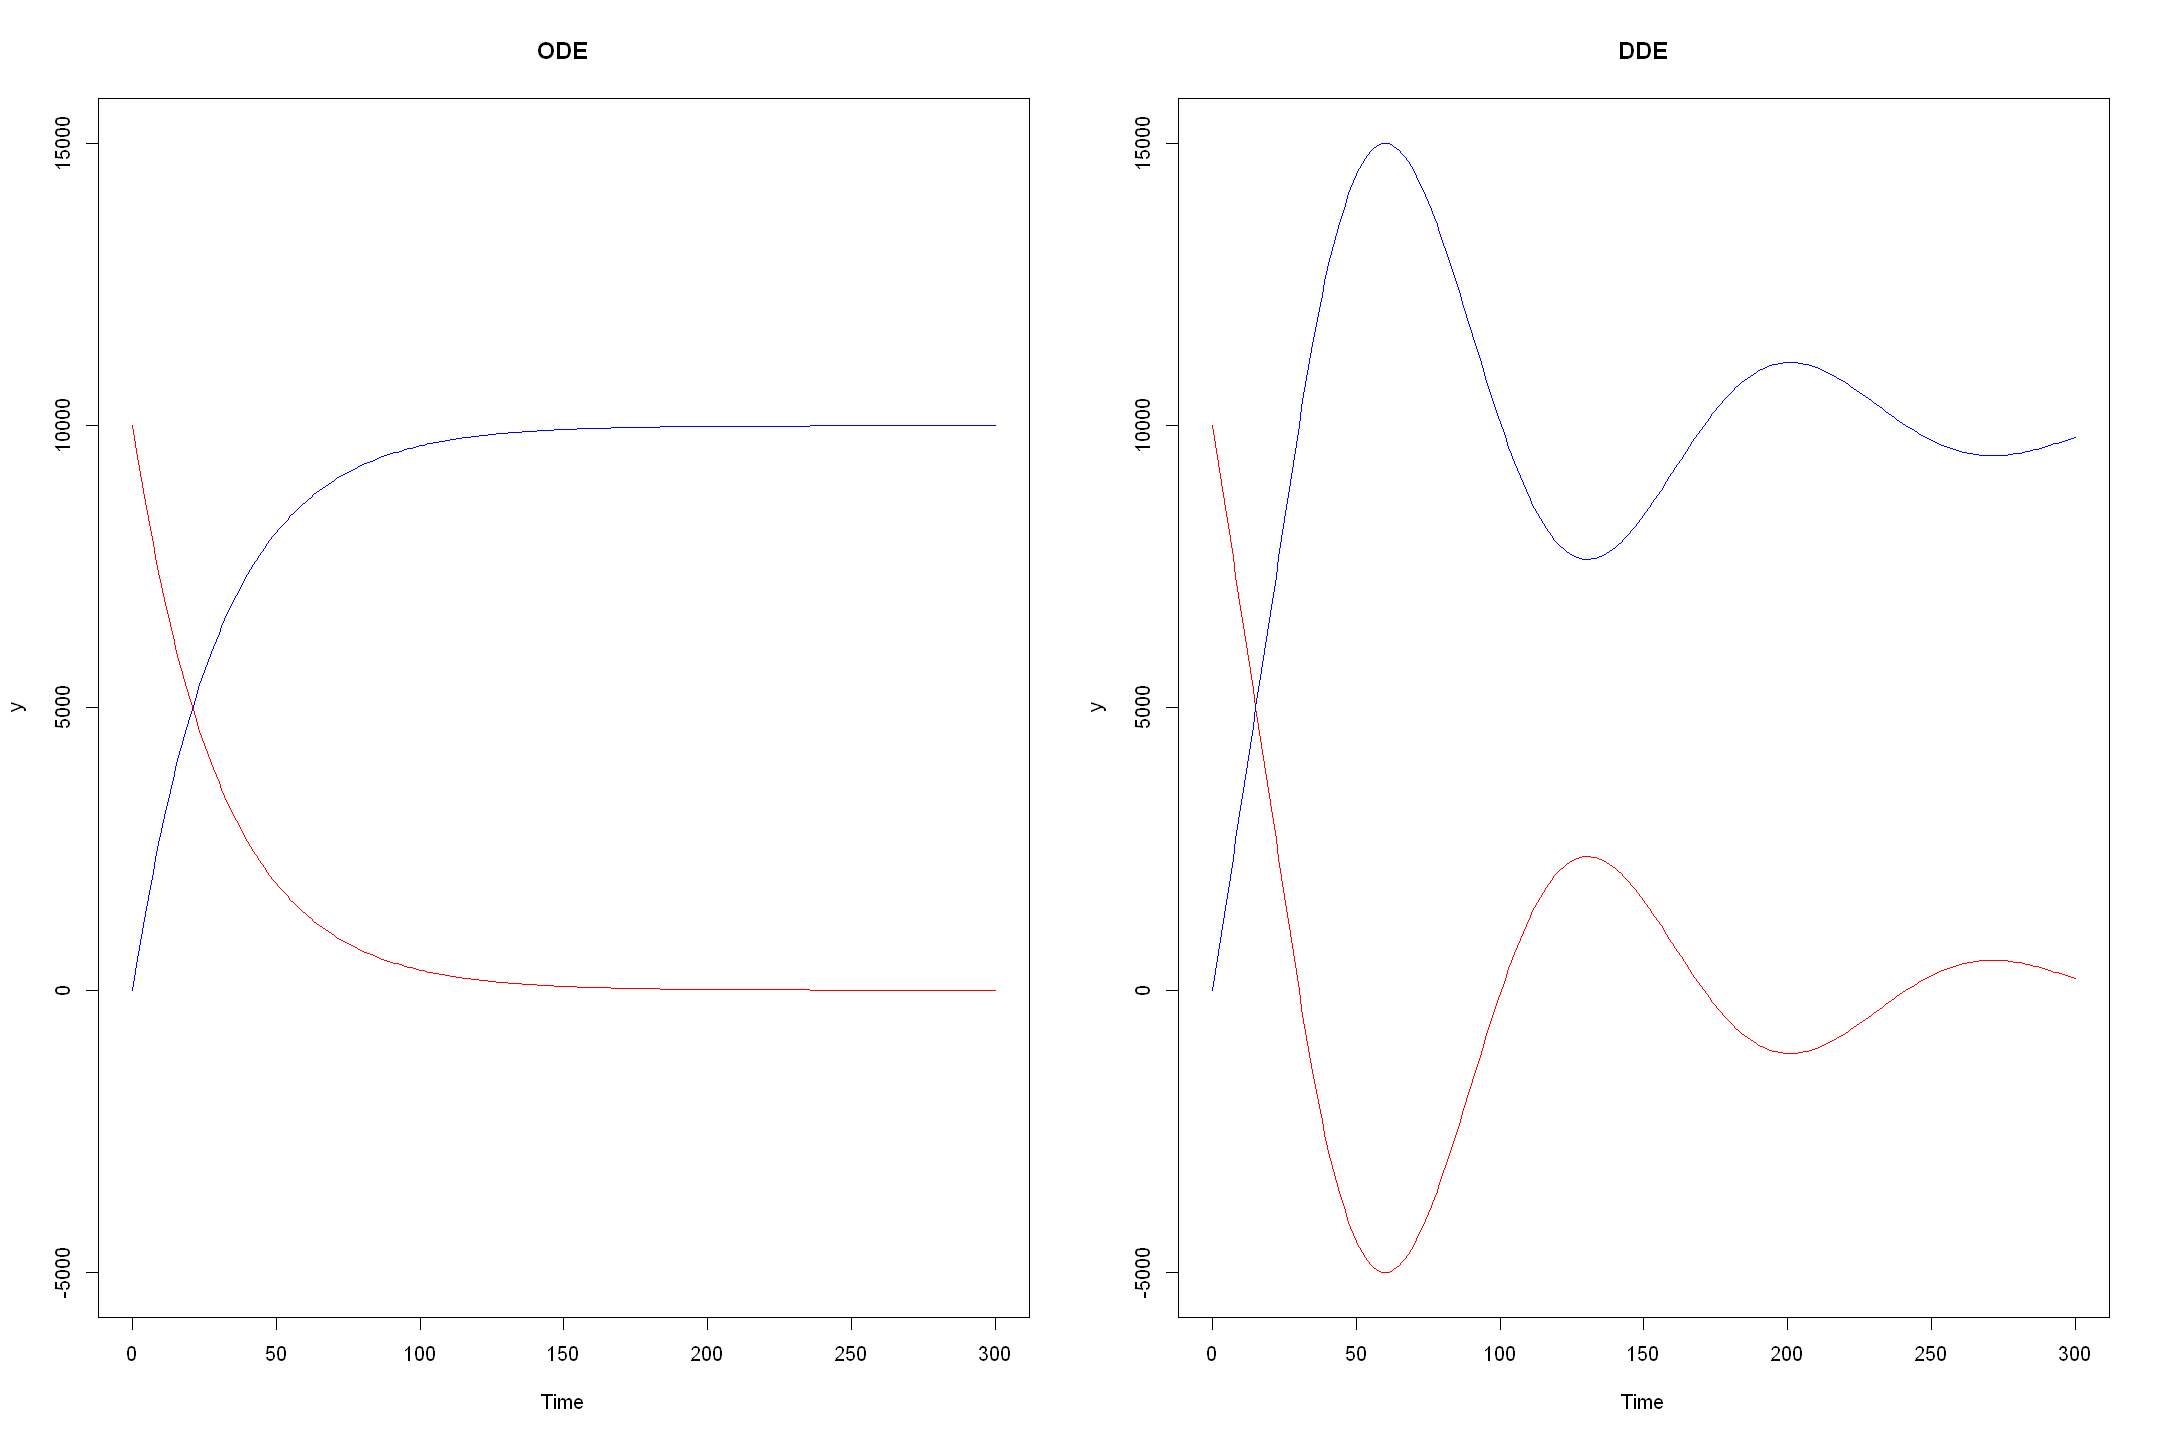

In [1]:
#########################Initial comparison#########################
options(warn=-1,repr.plot.width=18, repr.plot.height=12)

library(PBSddesolve)
library(wesanderson)
library(ggplot2)
library(colorspace)
library(dplyr)
library(magrittr)

tau = 30      #The stage duration
rate = 1/tau  #The equivalent growth rate

times = seq(0, 300 , 1) #Times to be simulated

y0 <- c(10000,0)   #Initial conditions
lags <- c(10000,0) #Initial history
derivs <- c(0,0)   #Vector to store outputs

#A simple ODE turning y1s into y2s at a constant rate
ode_grad <- function(t, y){

          derivs[1] <- -rate * y[1]
          derivs[2] <-  rate * y[1]
          
          return(derivs)
}
#A simple ODE turning y1s into y2s after a constant delay
dde_grad <- function(t, y){

    #Defines the current state of the lagged variables and 
    #if t - tau < 0 invokes the initial history
    if(t - tau <= 0){ylag <- y0}else{ylag <-  pastvalue(t - tau)} 
  
    #Note that ylag[1] recalls the state of y_1 tau units of time ago
    derivs[1] <- -rate * ylag[1] 
    derivs[2] <-  rate * ylag[1]
    
    return(derivs)
}

#Code to run the ODE
ode_example <- dde(y0, times, ode_grad, tol = 1e-5, hbsize = 1000000)
#Code to run the DDE
dde_example <- dde(y0, times, dde_grad, tol = 1e-5, hbsize = 1000000)

#Plots of model outputs

par(mfrow = c(1,2))

plot(ode_example[,1],ode_example[,2], type = "l",
     xlab = "Time", ylab = "y", col = "red", main = "ODE",
     ylim  = c(min(c(dde_example[,2],dde_example[,3])),
              max(c(dde_example[,2],dde_example[,3])))) + 
     lines(ode_example[,1],ode_example[,3], type = "l", xlab = "Time", col = "blue")

plot(dde_example[,1],dde_example[,2], type = "l", 
     xlab = "Time", ylab = "y", col = "red" , main = "DDE",
     ylim  = c(min(c(dde_example[,2],dde_example[,3])),
               max(c(dde_example[,2],dde_example[,3])))) + 
  lines(dde_example[,1],dde_example[,3], type = "l", xlab = "Time", col = "blue")


The solution to the previous DDE goes negative and predicts a population that is too large because we did not carefully define the systems history. Intuitively this occurs because the delay looks backwards to the past and "sees" $\tau$ days of $y_1 = 10,000$, which then get fed through to $y_2$ despite our initial intention to only have $10,000$ individuals. This results in the strange oscillatory dynamics as the system compensates. To fix this we could either be more careful with how we define the systems history or much lazier with how we define the initial conditions. Because we eventually will have a very complex system with many stages, states, and life-history processes we opt to be lazy and set initial conditions $y_1(0)=0, y_2(0) = 0$ and with history $y_1(t)=0, y_2(t) = 0$ for $t<0$. To initiate the dynamics we instead define an impulse function, $I(t)$, that is $0$ everywhere apart for when $t\in[0,10]$ for which we will have $I(t) = 1,000$ to introduce the $10,000$ individuals we intended to start with at a rate of $1,000$ individuals per day. The new ODE system is defined 

$$\begin{align}\frac{dy_1}{dt} &=  I(t) -ry_1(t) \\
\frac{dy_2}{dt} &= ry_1(t) 
\end{align}$$

and the new DDE is defined

$$\begin{align}\frac{dy_1}{dt} &= I(t)-I(t - \tau)\\
\frac{dy_2}{dt} &= I(t - \tau).
\end{align}$$

Once you've run the model with the supplied parameters, try changing both the impulse function and the delay to get a feel for how the two models compare.

integer(0)

integer(0)

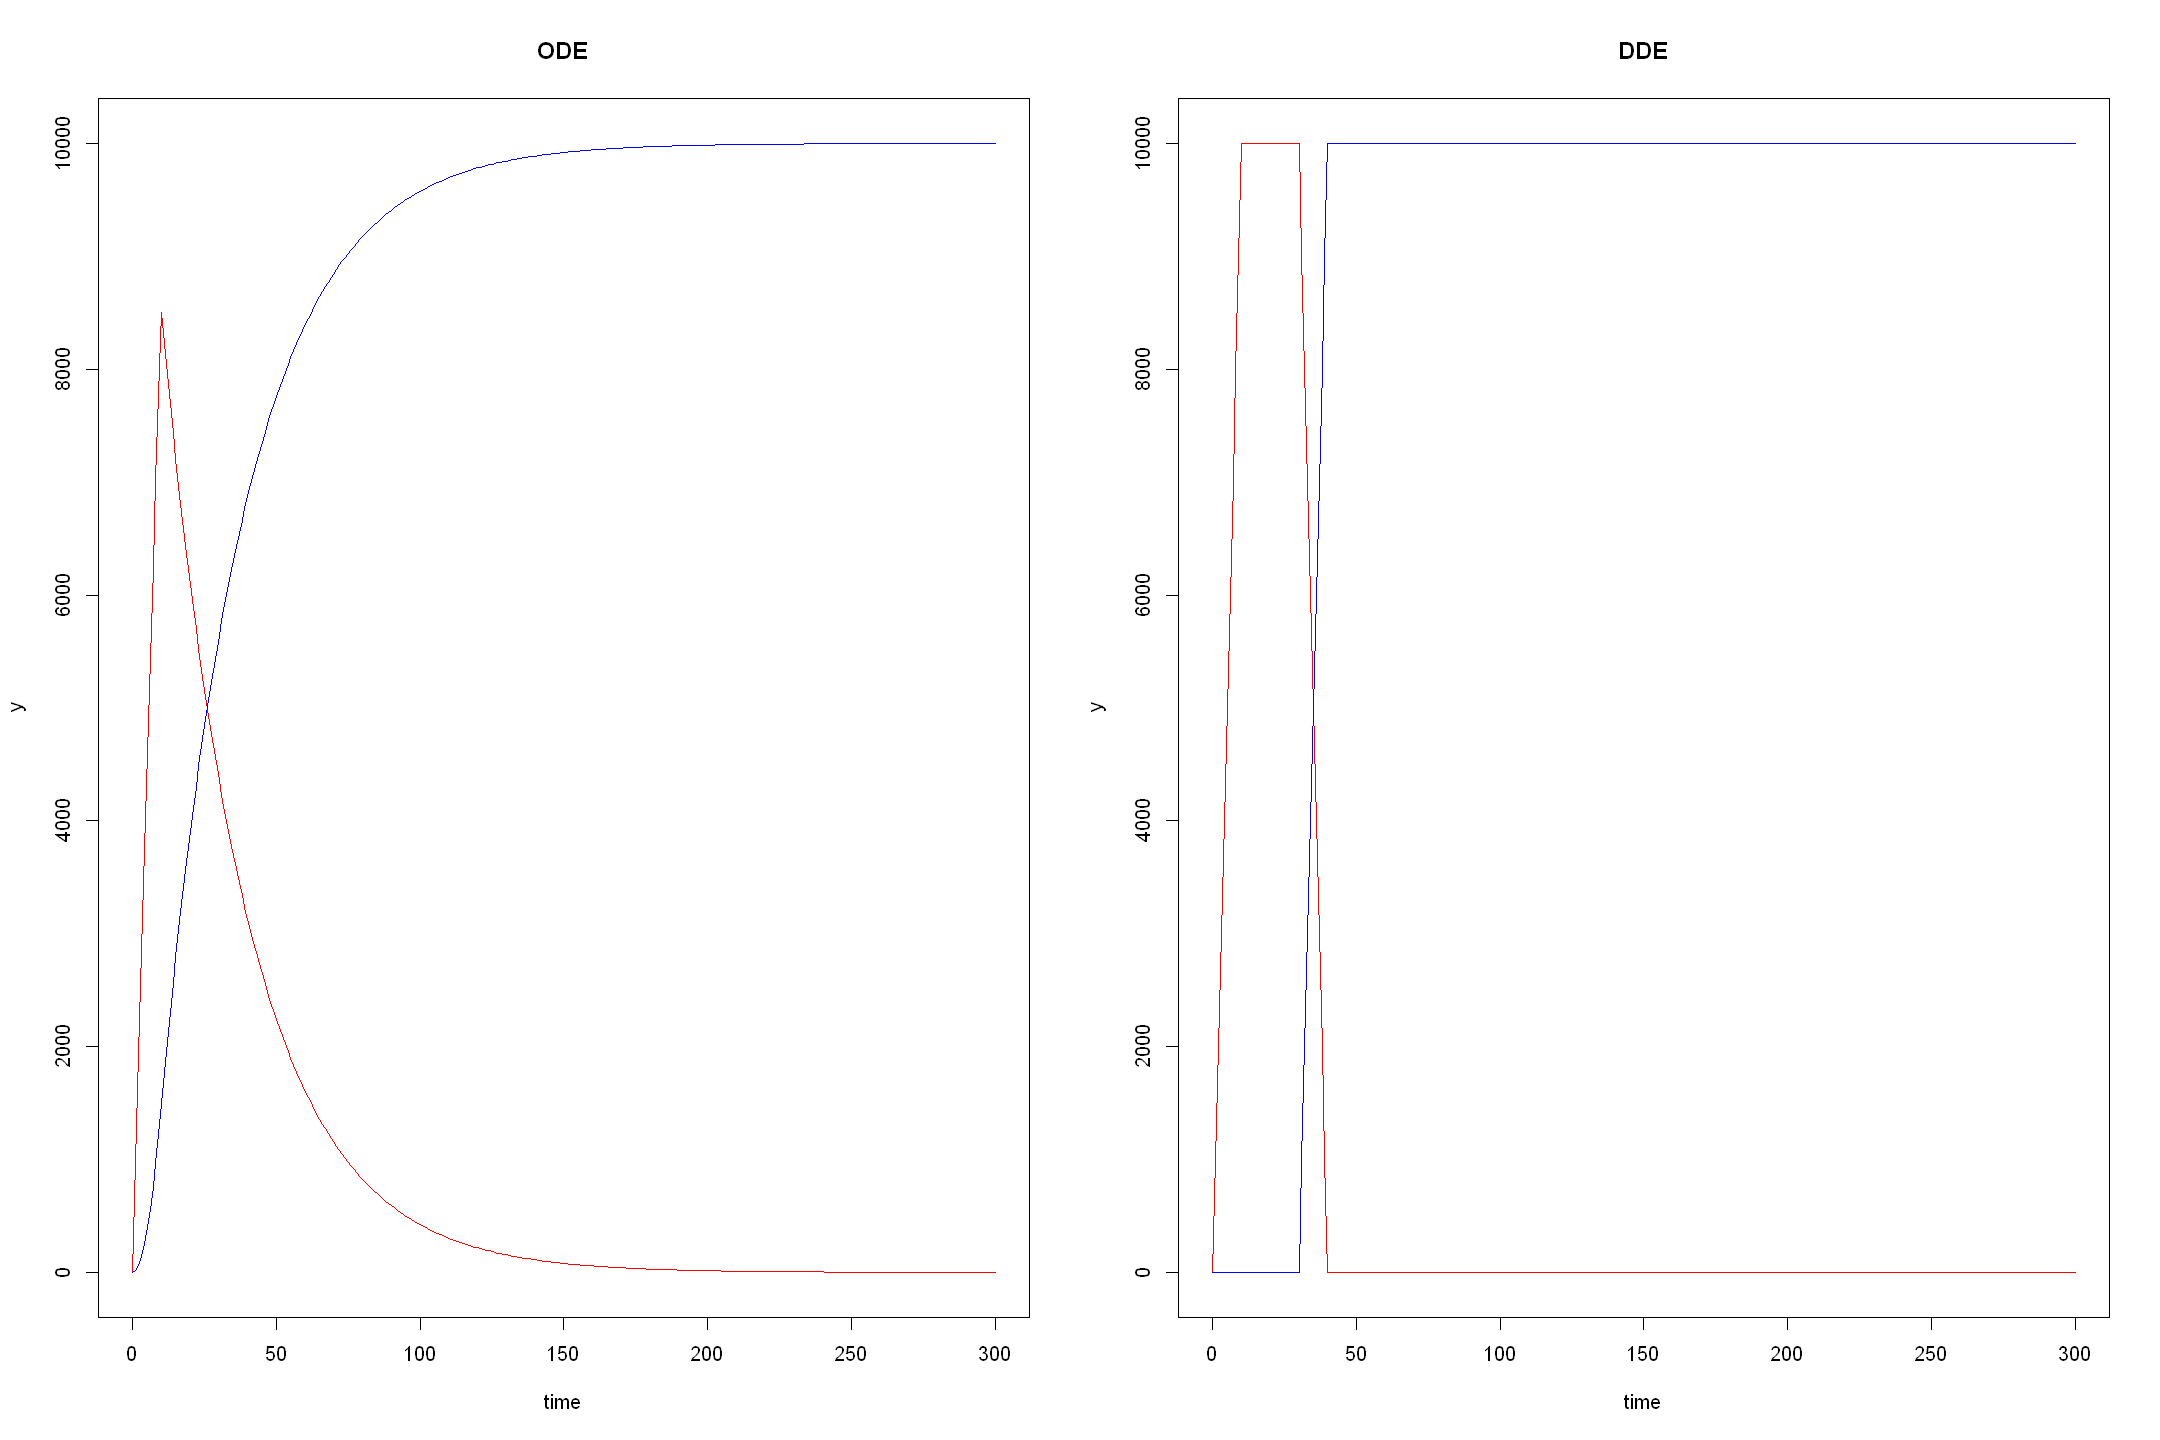

In [2]:
#########################Impulse#########################

y0     <-  rep(0,2) #Initial conditions
lags   <-  rep(0,2) #Initial history
derivs <-  rep(0,2) #Initiates derivative store

times = seq(0, 300 , 1) #Times to be simulated

tau = 30     #The stage duration
rate = 1/tau  #Equivalent rate

#Impulse function to start dynamics
impulse <- function(t){
                if(t > 0 && t < 10){
                  1000
                }else{
                  0 
                }
              }

ode_gradimpulse <- function(t, y){

    derivs[1] <- -rate * y[1] + impulse(t)
    derivs[2] <-  rate * y[1] 
    
    
    return(derivs)
}

dde_gradimpulse  <- function(t, y){

    #Individuals leave y1 at time t at the rate they entered it at time t - tau
    derivs[1] <-  impulse(t          ) -  impulse(t -     tau)
    derivs[2] <-  impulse(t -     tau) 

    return(derivs)
}


ode_impulse <- dde(y0, times, ode_gradimpulse, tol = 1e-5, hbsize = 1000000)
dde_impulse <- dde(y0, times, dde_gradimpulse, tol = 1e-5, hbsize = 1000000)
par(mfrow = c(1,2))

plot(ode_impulse[,1],ode_impulse[,2], type = "l", 
     xlab = "time", ylab= "y", main = "ODE", col = "red", 
    ylim  = c(min(c(ode_impulse[,2],ode_impulse[,3])),max(c(ode_impulse[,2],dde_impulse[,3])))) + 
  lines(ode_impulse[,1],ode_impulse[,3], type = "l", col = "blue") 

plot(dde_impulse[,1],dde_impulse[,2], type = "l", 
    xlab = "time", ylab= "y", main = "DDE",col = "red", 
    ylim  = c(min(c(dde_impulse[,2],dde_impulse[,3])),max(c(dde_example[,2],dde_impulse[,3])))) + 
  lines(dde_impulse[,1],dde_impulse[,3], type = "l", col = "blue")


The effect of accounting for the movement of individuals from one stage to the next in different ways can be seen more clearly when we consider more stages. See for example this $5$-stage model that follows the same basic pattern as the previous, notice the effect that assuming a constant transfer of individuals to the next stage at a constant rate has on when we first observe individuals.

integer(0)

integer(0)

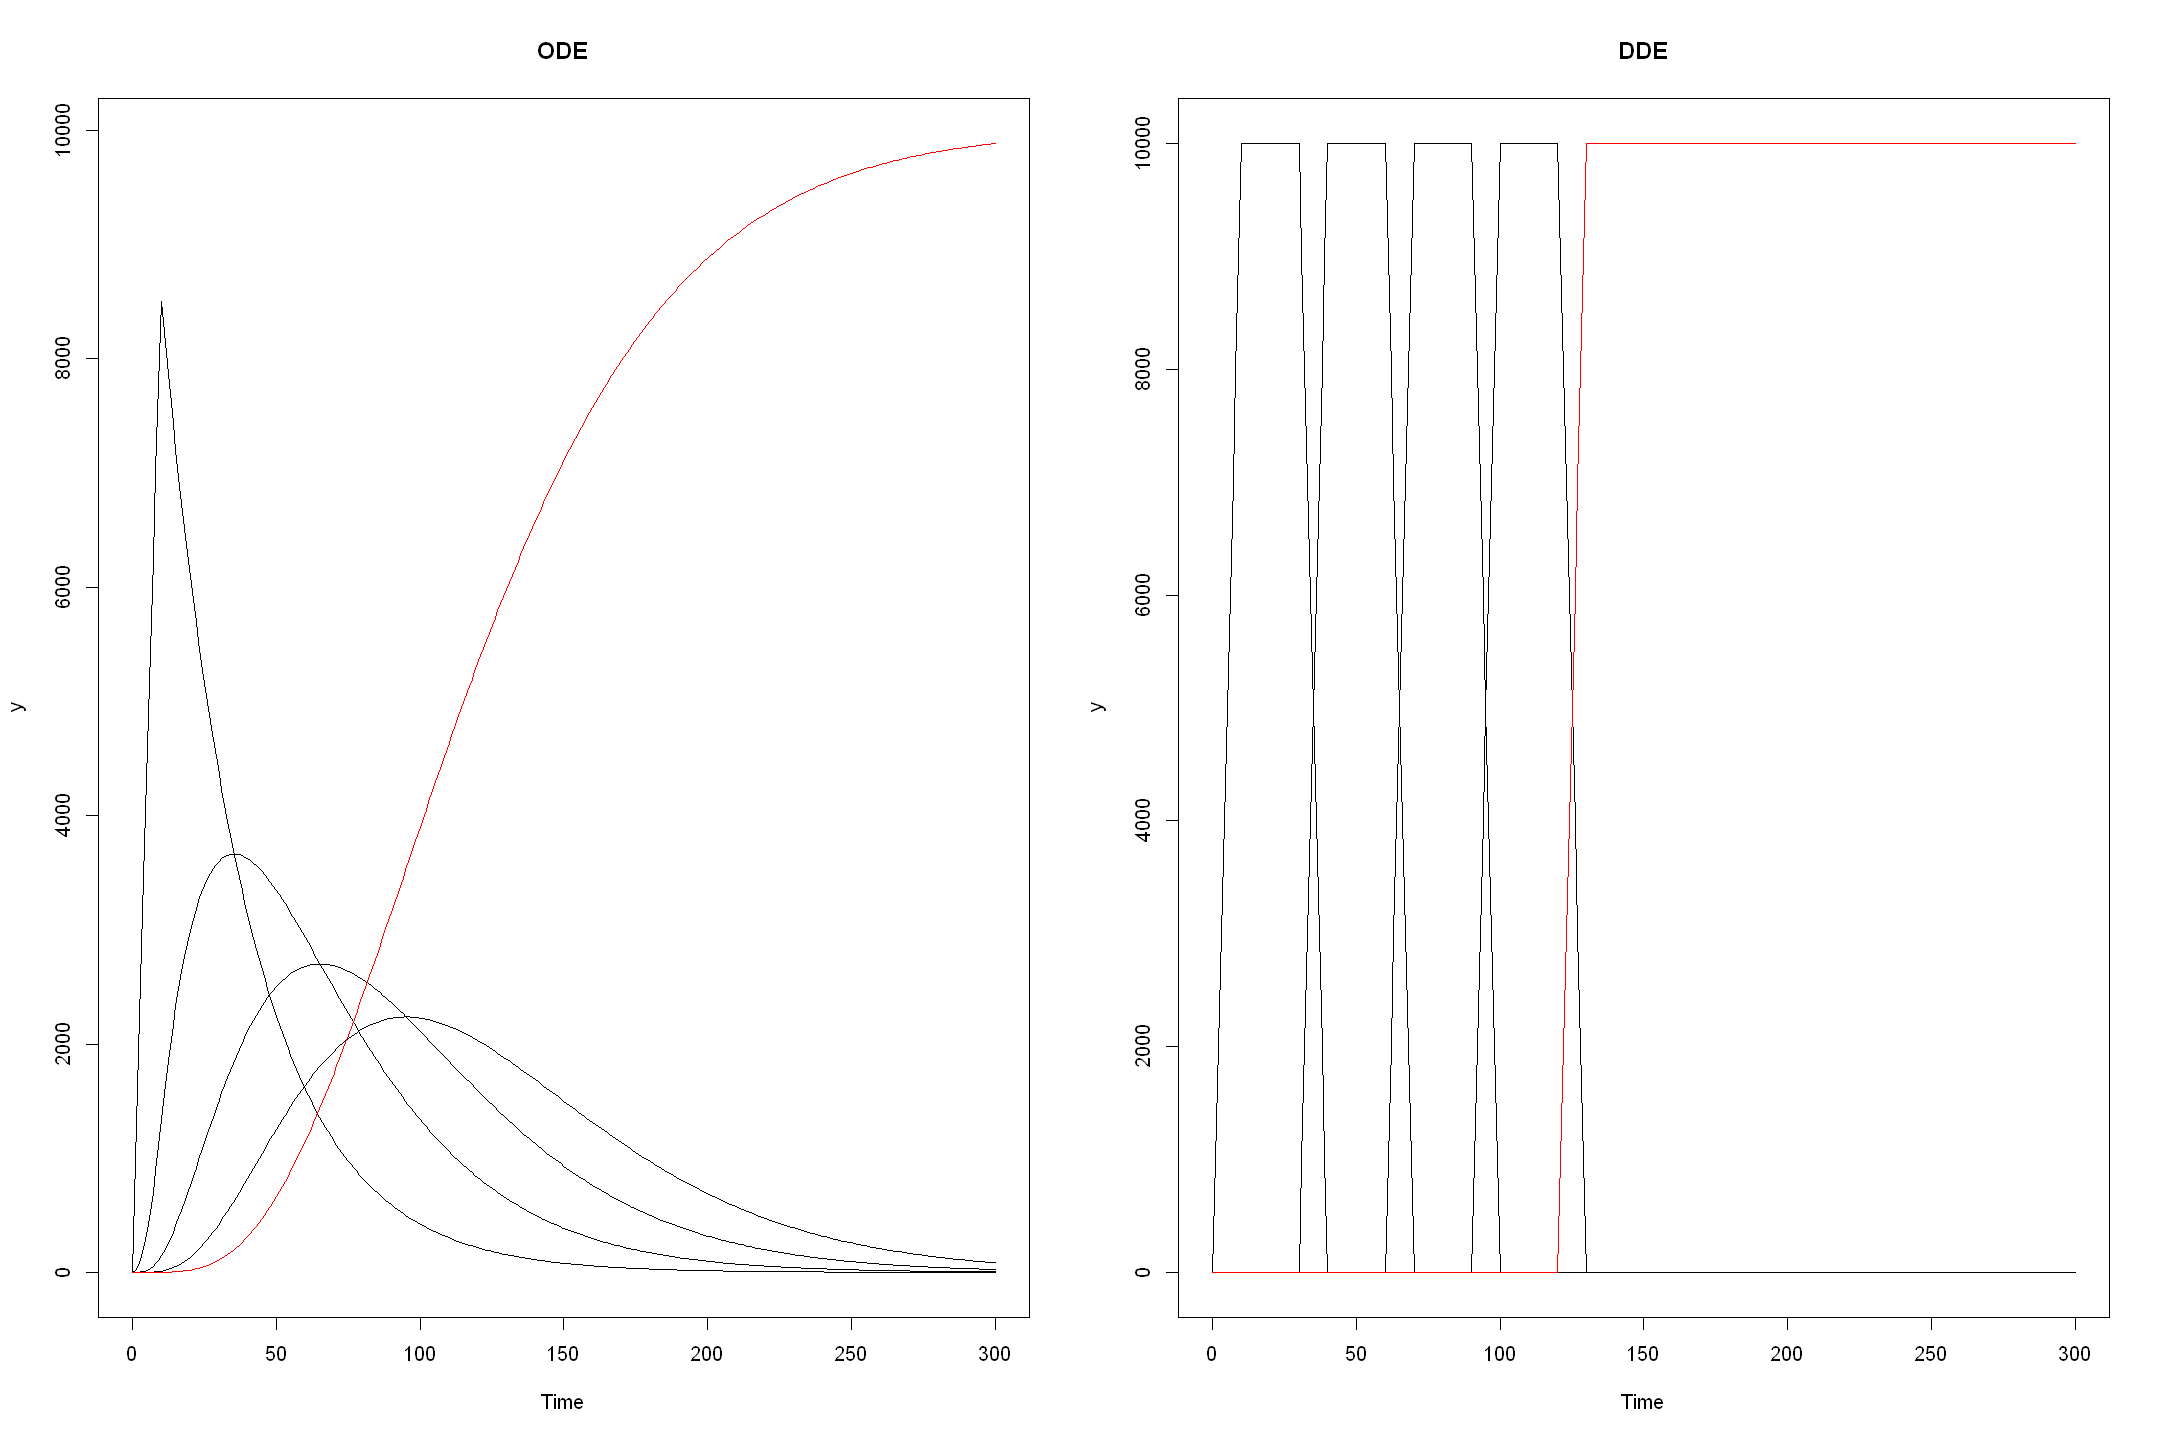

In [3]:
#########################Impulse multi-stage#########################

tau = 30
rate = 1/tau
times = seq(0, 300 , 1) #Times to be simulated

impulse <- function(t){
  if(t > 0 && t < 10){
    1000
  }else{
    0 
  }
}

y0 <- rep(0,5)
lags <- rep(0,5)
derivs <- rep(0,5)

ode_gradimpulsemult <- function(t, y){

    derivs[1] <- -rate * y[1] + impulse(t)
    derivs[2] <-  rate * y[1] - rate * y[2]
    derivs[3] <-  rate * y[2] - rate * y[3]
    derivs[4] <-  rate * y[3] - rate * y[4]
    derivs[5] <-  rate * y[4]
    
    
    return(derivs)
}

dde_gradimpulsemult  <- function(t, y){
    
    derivs[1] <-  impulse(t          ) -  impulse(t -     tau)
    derivs[2] <-  impulse(t -     tau) -  impulse(t - 2 * tau)
    derivs[3] <-  impulse(t - 2 * tau) -  impulse(t - 3 * tau)
    derivs[4] <-  impulse(t - 3 * tau) -  impulse(t - 4 * tau)
    derivs[5] <-  impulse(t - 4 * tau) 
    
    return(derivs)
}

par(mfrow = c(1,2))
ode_impulsemult <- dde(y0, times, ode_gradimpulsemult, tol = 1e-5,  hbsize = 1000000)
dde_impulsemult <- dde(y0, times, dde_gradimpulsemult, tol = 1e-5,  hbsize = 1000000)
plot(ode_impulsemult[,1]   , ode_impulsemult[,2], main ="ODE",type = "l",
     xlab = "Time", ylab = "y", ylim  = c(min(c(ode_impulsemult[,2],ode_impulsemult[,3])),
                                         max(c(ode_impulsemult[,2],ode_impulsemult[,6])))) + 
  lines(ode_impulsemult[,1], ode_impulsemult[,3], type = "l", xlab = "Time", ylab = "y_2") +
  lines(ode_impulsemult[,1], ode_impulsemult[,4], type = "l", xlab = "Time", ylab = "y_3") +
  lines(ode_impulsemult[,1], ode_impulsemult[,5], type = "l", xlab = "Time", ylab = "y_4") +
  lines(ode_impulsemult[,1] ,ode_impulsemult[,6], type = "l", xlab = "Time", ylab = "y_5",col = "red")

plot(dde_impulsemult[,1],dde_impulsemult[,2],  main = "DDE",type = "l", 
     xlab = "Time", ylab = "y", ylim  = c(min(c(dde_impulsemult[,2],dde_impulsemult[,3])),
                                            max(c(dde_impulsemult[,2],dde_impulsemult[,3])))) + 
  lines(dde_impulsemult[,1],dde_impulsemult[,3], type = "l", xlab = "Time") +
  lines(dde_impulsemult[,1],dde_impulsemult[,4], type = "l", xlab = "Time") +
  lines(dde_impulsemult[,1],dde_impulsemult[,5], type = "l", xlab = "Time") +
  lines(dde_impulsemult[,1],dde_impulsemult[,6], type = "l", xlab = "Time",col = "red")


## Density dependence

So far, we have seen the effect that delays can have on the timing of events within a system. This is intuitive, but delays can also have less obvious effects on population dynamics especially in instances where there is delayed-density dependence in the system. Consider the dynamical behaviour of the following ODE describing logistic growth where the population increases with rate $r$ and has carrying capacity $K$:

$$\frac{dy}{dt} = ry\left(1-\frac{y(t)}{K}\right)$$

and a DDE describing delay logistic growth

$$\frac{dy}{dt} = ry\left(1-\frac{y(t - \tau)}{K}\right)$$

We implement the models:

In [4]:

impulse <- function(t){
  if(t > 0 && t < 1){
    100
  }else{
    0 
  }
}
times = seq(0, 300 , 1)

y0 <- rep(0,1)
lags <- rep(0,1)
derivs <- rep(0,1)


ode_logistic  <- function(t, y){

    derivs[1] <-  rate * y[1] * (1 - y[1]/K) + impulse(t)
    
    return(derivs)
}

dde_logistic  <- function(t, y, parms){

    if(t - tau <= 0){ylag_E <- lags}else{ylag_E <-  pastvalue(t - tau)}
    
    derivs[1] <-  rate * y[1] * (1 - ylag_E/K) + impulse(t)
    
    return(derivs)
}



Try simulating the system for different values of $\tau$, what do you observe as the delay increases?

integer(0)

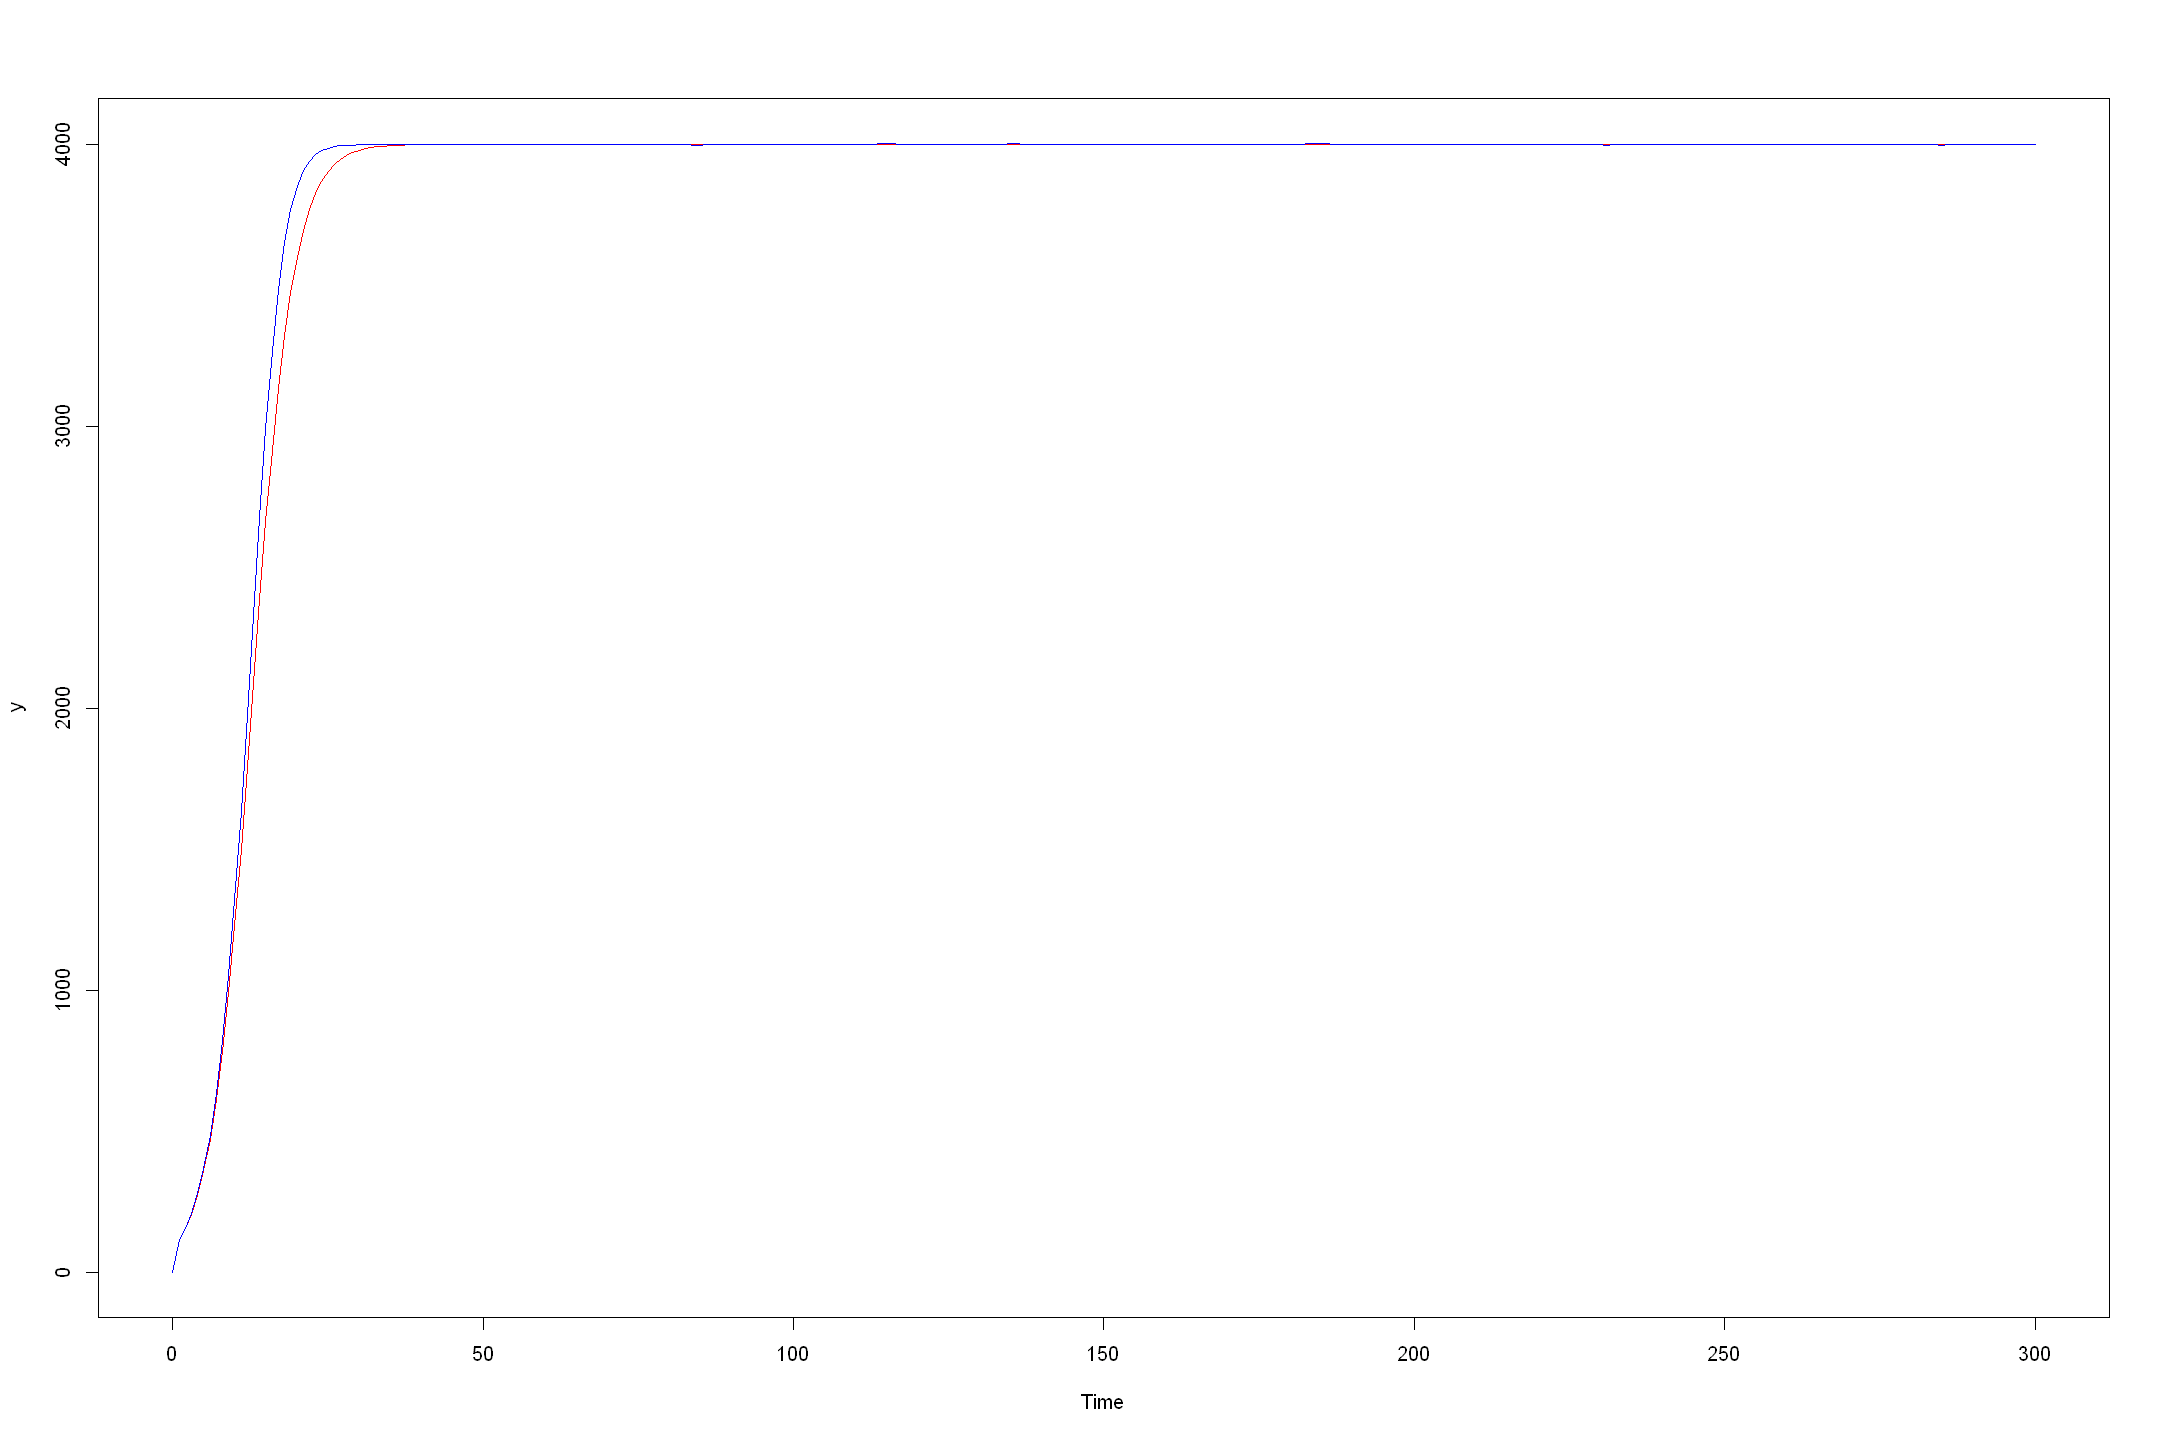

In [5]:
tau = 1
rate = 0.3
K =4000

ode_logout <- dde(y0, times, ode_logistic, tol = 1e-5, hbsize = 1000000)
dde_logout <- dde(y0, times, dde_logistic, tol = 1e-5, hbsize = 1000000)

par(mfrow = c(1,1))

plot(ode_logout[,1],ode_logout[,2], type = "l", 
      xlab = "Time", col = "red",ylab = "y", ylim  = c(min(c(ode_logout[,2],ode_logout[,2])),
      max(c(ode_logout[,2],dde_logout[,2])))) +
    lines(dde_logout[,1],dde_logout[,2], type = "l", 
      xlab = "Time",col = "blue", ylab = "y", 
      ylim  = c(min(c(dde_logout[,2],dde_logout[,2])),max(c(dde_logout[,2],dde_logout[,2])))) 


So we might want to think about using a DDE when we care about timing or when we are interested in the effects of density dependence.

## The Nisbet and Gurney approach

The previous examples show that the dynamics of DDEs are often more complicated than we observe in similarly formulated ODEs. However, we need to also show that this extra complexity is justified and actually improve our understanding of population dynamics. To do this we introduce a standard framework within which to formulate DDEs and examine our first serious DDE model of population dynamics. 

We will consider the dynamics of a laboratory system of caged blowflies that Nicholson kept in 1950 (described in "The Self-Adjustment of Populations to Change" - A. J. NICHOLSON). The blowflies were kept at a constant temperature and provided with a fixed amount of food every day, with larval and adult food supplies separated. Larval food was assumed to be in excess (we will return to this assumption later) and adult food was supplied at a level that it was the factor limiting the size of the population. The Nicholson observed that the effect of competition for adult food on adult traits was a reduction in the number of eggs laid, which he measured through a series of experiments. The dynamics expressed by the fly population were characterised by oscillatory cycles, with periods of high adult abundance but low numbers of eggs and low adult abundance but high numbers of eggs.

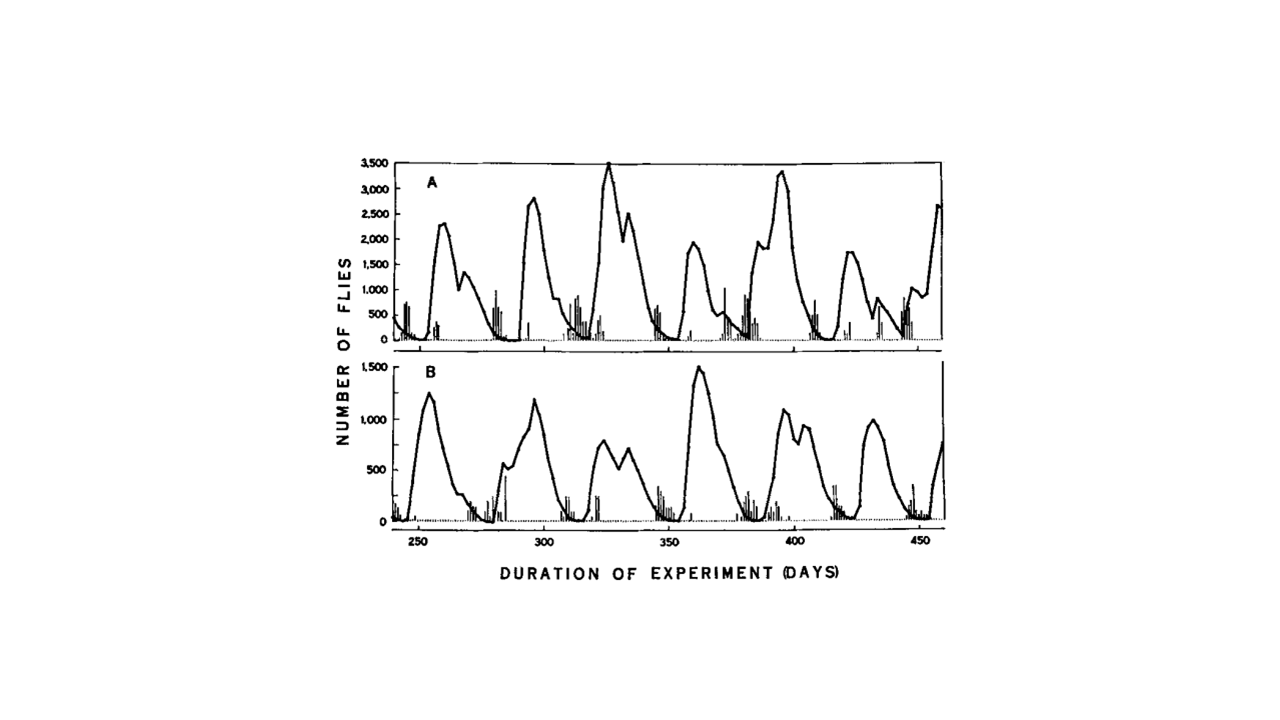

In "Nicholson's blowflies revisited" W. S. C. Gurney, S. P. Blythe & R. M. Nisbet propose a system of DDEs to model this population which we will now simulate which then became the basis of a framework we can use to create stage-structured systems of DDEs without worrying too much about the analytics. 

We define the rates of change in the state variables in terms of recruitment into a stage $R_X(t)$, maturation out of a stage $M_X(t)$. For each stage we additionally define a duration $\tau_X$, and a mortality rate, $\delta_X$, which we additionally use to define a through-stage survival proportion $P_X = \exp(-\delta_X\tau_X)$. 

Recruitment into the egg stage, E(t), is defined $$R_E(t) = 8.5A(t)\exp(-A(t)/600) + I(t)$$ representing the effect of food limitation on egg production. Maturation out of the egg stage and into the larval stage is the defined $$\begin{align}M_E(t) &= R_L(t)\\ &= R_E(t - \tau_E)P_E\\ &= (8.5A(t-\tau_E)\exp(-A(t-\tau_E)/600 + I(t-\tau_E))P_E\end{align},$$ which states that the rate at which individuals leave the egg stage at time $t$ is equal to the rate they entered the egg stage one development period ago modified by the proportion of individuals that survived development. We then can similarly recursively define the rest of the recruitment and maturation rates using a similar logic, i.e. $$\begin{align}M_{i}(t) &= R_{i+1}(t)\\ &= R_{i}(t - \tau_L)P_i\end{align}$$ and so on. This results in the following system of equations:
$$
\begin{align}
\frac{dE}{dt} &= R_E(t) - M_E(t) - \delta_EE(t),\\
\frac{dL}{dt} &= R_L(t) - M_L(t) - \delta_LL(t),\\
\frac{dP}{dt} &= R_P(t) - M_P(t) - \delta_PP(t),\\
\frac{dJ}{dt} &= R_J(t) - M_J(t) - \delta_JJ(t),\\
\frac{dA}{dt} &= R_A(t)  - \delta_AA(t).
\end{align}
$$

We compare the dynamics of this system to an equivalent system of ODEs where we represent development with rates rather than durations, i.e $g_E = 1/\tau_E$: 

$$
\begin{align}
\frac{dE}{dt} &= R_E(t) - g_EE(t) - \delta_EE(t),\\
\frac{dL}{dt} &= g_EE(t) - g_LL(t) - \delta_LL(t),\\
\frac{dP}{dt} &= g_LL(t) - g_PP(t) - \delta_PP(t),\\
\frac{dJ}{dt} &= g_PP(t) - g_JJ(t)  - \delta_JJ(t),\\
\frac{dA}{dt} &= g_JJ(t)   - \delta_AA(t).
\end{align}
$$

We define the model

In [6]:
#########################Population dynamics - blowflies#########################

#Defines the impulse function we will use to start the dynamics
impulse <- function(t){
  if(t > 0 && t < 1){
    10
  }else{
    0 
  }
}

#Vector of times to solve for
times = seq(0, 150 , 1)

#Initialises the initial conditions, history and derivative vectors
y0 <- rep(0,5)
lags <- rep(0,5)
derivs <- rep(0,5)

#ODE blowfly model
ode_blowfly  <- function(t, y){

    derivs[1] <-  8.5 * y[5] * exp(-y[5]/600) - rate_E * y[1] - delta_E * y[1] + impulse(t)
    derivs[2] <-  rate_E * y[1] - rate_L * y[2] - delta_L * y[2]
    derivs[3] <-  rate_L * y[2] - rate_P * y[3] - delta_P * y[3]
    derivs[4] <-  rate_P * y[3] - rate_J * y[4] - delta_J * y[4]
    derivs[5] <-  rate_J * y[4]                 - delta_A * y[5]
    
    return(derivs)
}

#DDE blowfly model
dde_blowfly  <- function(t, y){

    #Defines the lagged state variable conditions
    if(t - tau_E                        <= 0){ylag_E       <- lags}else{ylag_E       <-  pastvalue(t - tau_E)}
    if(t - tau_E - tau_L                <= 0){ylag_E_L     <- lags}else{ylag_E_L     <-  pastvalue(t - tau_E - tau_L)}
    if(t - tau_E - tau_L - tau_P        <= 0){ylag_E_L_P   <- lags}else{ylag_E_L_P   <-  pastvalue(t - tau_E - tau_L - tau_P)}
    if(t - tau_E - tau_L - tau_P - tau_J<= 0){ylag_E_L_P_J <- lags}else{ylag_E_L_P_J <-  pastvalue(t - tau_E - tau_L - tau_P - tau_J)}
    
    R_E     = 8.5 * y[5] * exp(-y[5]/600) +
              impulse(t)
    R_E_lag = 8.5 * ylag_E[5] * exp(-ylag_E[5]/600) * S_E +
              impulse(t - tau_E) * S_E
    
    R_L     = 8.5 * ylag_E[5] * exp(-ylag_E[5]/600) * S_E +
              impulse(t - tau_E) * S_E 
    R_L_lag = 8.5 * ylag_E_L[5] * exp(-ylag_E_L[5]/600) * S_E * S_L +
              impulse(t - tau_E - tau_L) * S_E * S_L
    
    R_P     = 8.5 * ylag_E_L[5] * exp(-ylag_E_L[5]/600) * S_E * S_L +
              impulse(t - tau_E - tau_L) * S_E * S_L
    R_P_lag = 8.5 * ylag_E_L_P[5] * exp(-ylag_E_L_P[5]/600) * S_E * S_L * S_P +
              impulse(t - tau_E - tau_L - tau_P) * S_E * S_L * S_P
    
    R_J     = 8.5 * ylag_E_L_P[5] * exp(-ylag_E_L_P[5]/600)   * S_E * S_L * S_P +
              impulse(t - tau_E - tau_L - tau_P)  * S_E * S_L * S_P
    R_J_lag = 8.5 * ylag_E_L_P_J[5] * exp(-ylag_E_L_P_J[5]/600) * S_E * S_L * S_P * S_J +
              impulse(t - tau_E - tau_L - tau_P - tau_J) * S_E * S_L * S_P * S_J
    
    R_A     = 8.5 * ylag_E_L_P_J[5] * exp(-ylag_E_L_P_J[5]/600) * S_E * S_L * S_P * S_J +
      impulse(t - tau_E - tau_L - tau_P - tau_J) * S_E * S_L * S_P * S_J
    
    
    derivs[1] <-  R_E - R_E_lag - delta_E * y[1] 
    derivs[2] <-  R_L - R_L_lag - delta_L * y[2]
    derivs[3] <-  R_P - R_P_lag - delta_P * y[3]
    derivs[4] <-  R_J - R_J_lag - delta_J * y[4]
    derivs[5] <-  R_A           - delta_A * y[5]
    
    return(derivs)
}




In general we see that a very simple sort of density dependence naturally explains complex dynamics observed in a real population. Try changing the parameters what behaviours can you observe?

integer(0)

integer(0)

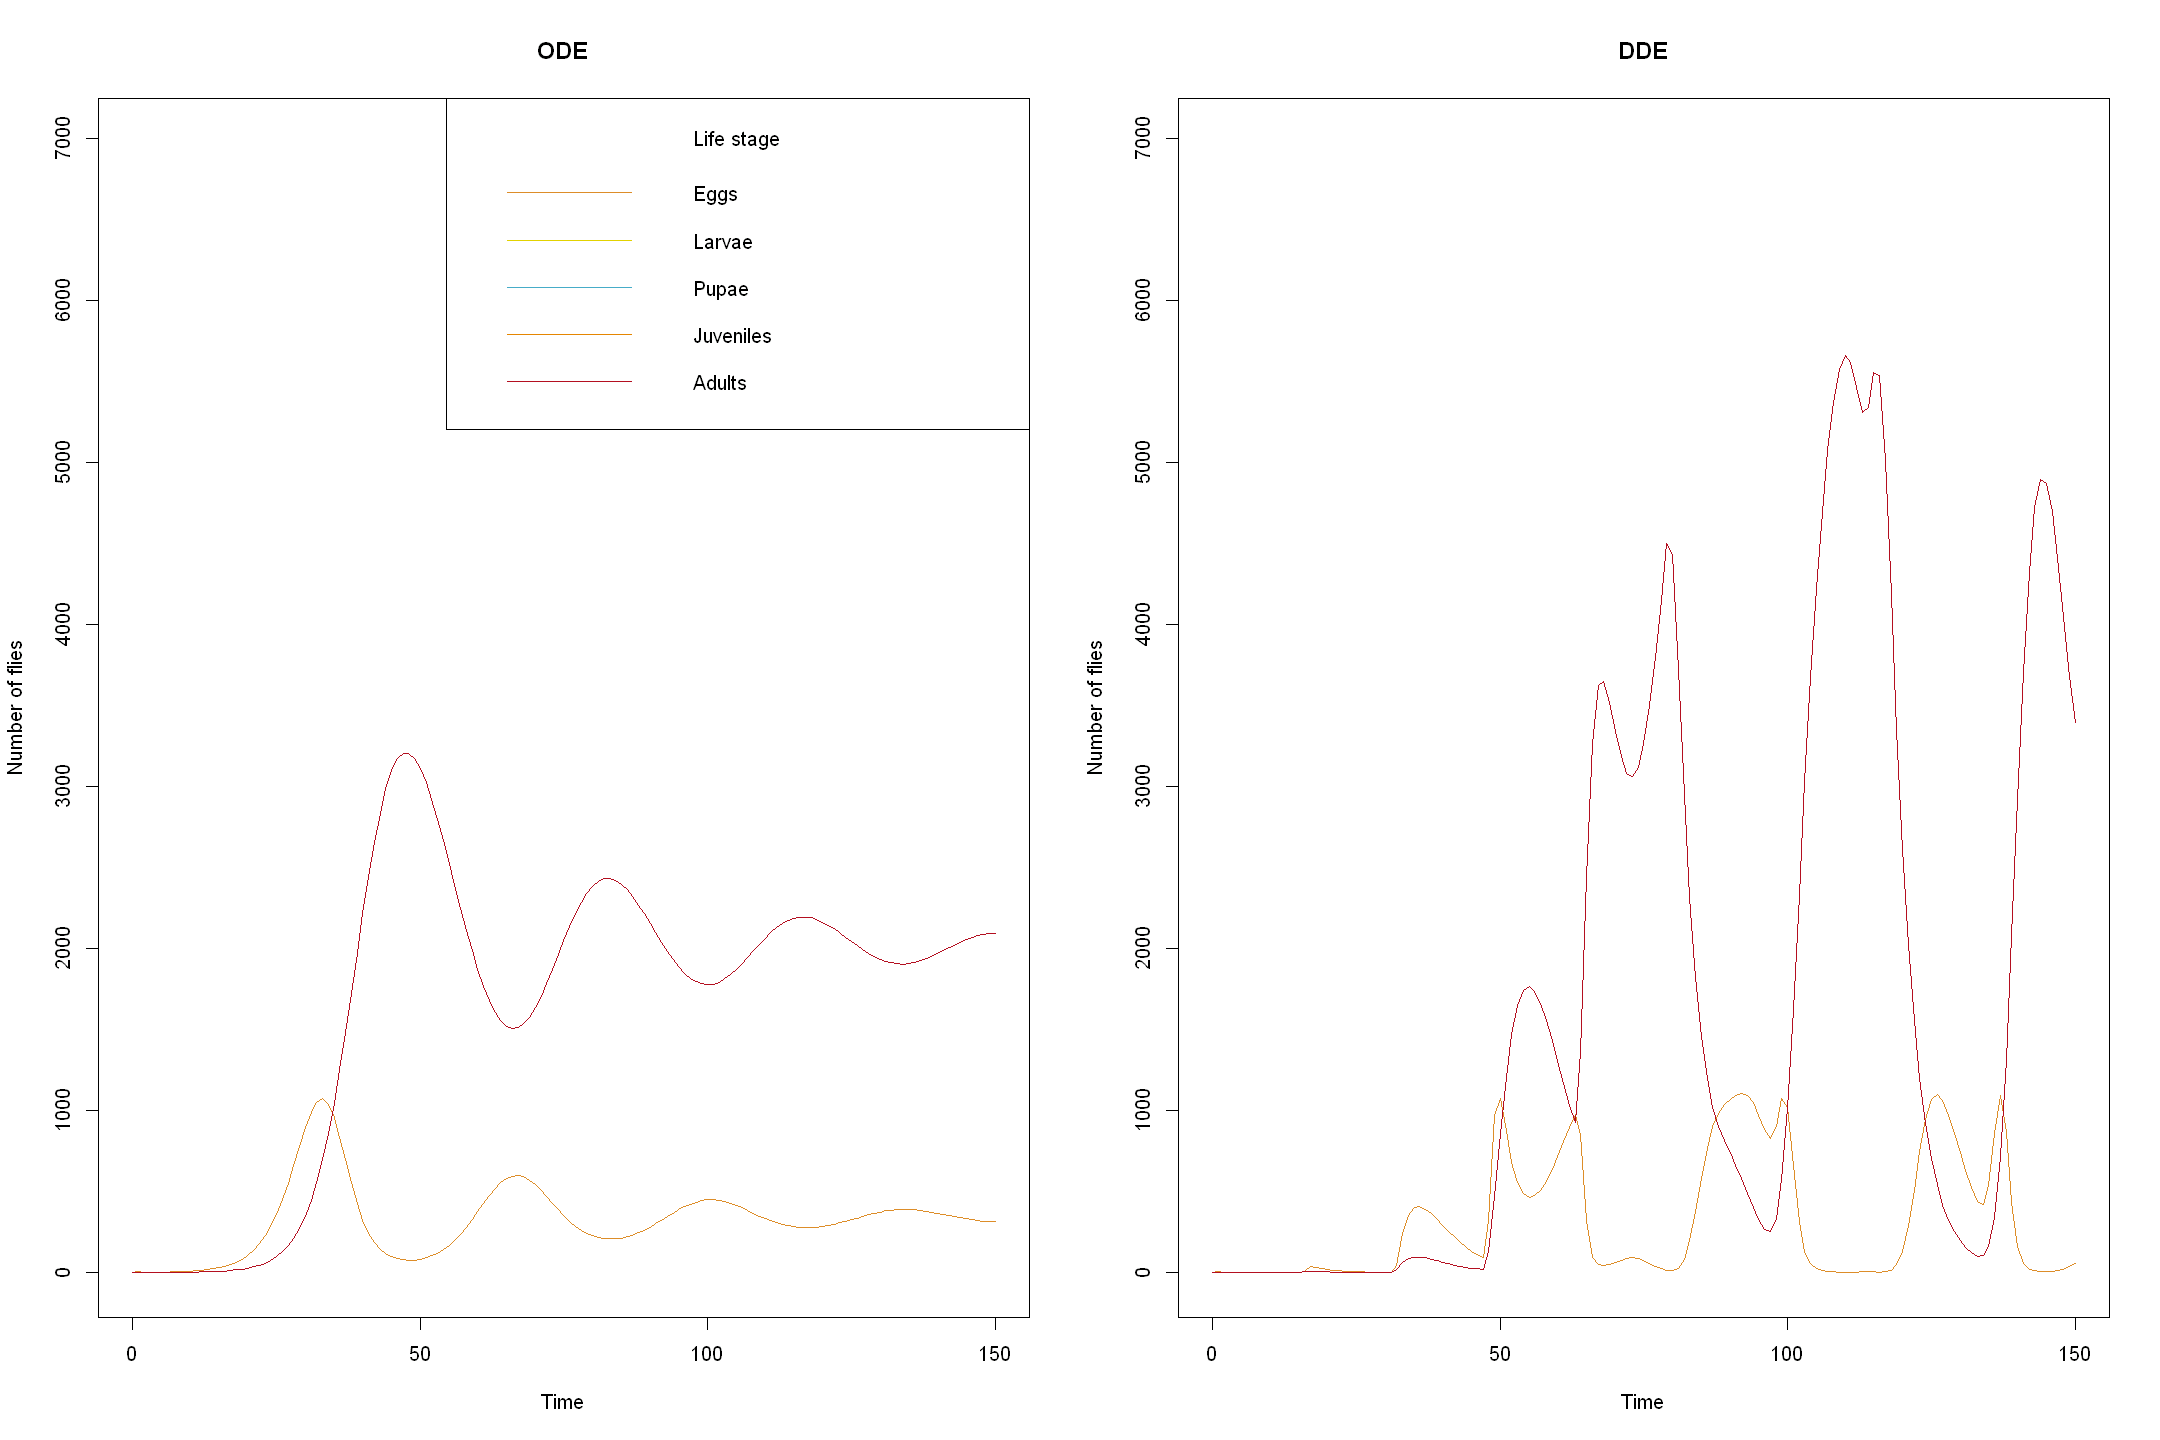

In [7]:
#Sets the constant developmental delays for the DDE
tau_E = 0.6
tau_L = 5
tau_P = 5.9
tau_J = 4.1
#Defines the equivalent development rates for the ODE 
rate_E = 1/tau_E
rate_L = 1/tau_L
rate_P = 1/tau_P
rate_J = 1/tau_J
#Sets stage-specific mortality rates
delta_E = 0.07
delta_L = 0.004
delta_P = 0.003
delta_J = 0.0025
delta_A = 0.27
#Defines through stage-survival proportions in terms of stage duration and mortality
S_E = exp(-tau_E * delta_E)
S_L = exp(-tau_L * delta_L)
S_P = exp(-tau_P * delta_P)
S_J = exp(-tau_J * delta_J)

ode_blowout <- dde(y0, times, ode_blowfly, tol = 1e-5, hbsize = 1000000)
dde_blowout <- dde(y0, times, dde_blowfly, tol = 1e-5, hbsize = 1000000)
pal <- wes_palette("FantasticFox1")
par(mfrow = c(1,2))
plot(ode_blowout[,1]   ,ode_blowout[,2], type = "l",main = "ODE",  
     xlab = "Time", lwd = 1.5, col = pal[1], ylab = "Number of flies", 
     ylim  = c(min(c(ode_blowout[,2],ode_blowout[,2])),max(c(ode_blowout[,2],dde_blowout[,5])))) +
  lines(ode_blowout[,1],ode_blowout[,6], type = "l", 
        xlab = "Time", lwd = 1.5, col = pal[5], ylim  = c(min(c(ode_blowout[,2],ode_blowout[,2])),
                                                          max(c(ode_blowout[,2],ode_blowout[,2])))) 
legend("topright", legend = c("Eggs", "Larvae", "Pupae", "Juveniles", "Adults"),
       text.width = strwidth("1,000,000"),
       lty = 1,col = pal, xjust = 1, yjust = 1,
       title = "Life stage")
plot(dde_blowout[,1]   ,dde_blowout[,2], type = "l",main = "DDE", 
     xlab = "Time", lwd = 1.5, col = pal[1], ylab = "Number of flies", 
     ylim  = c(min(c(dde_blowout[,2],dde_blowout[,2])),max(c(dde_blowout[,2],dde_blowout[,5])))) +
  lines(dde_blowout[,1],dde_blowout[,6], type = "l", 
        xlab = "Time", lwd = 1.5, col = pal[5], ylab = "y_1", 
        ylim  = c(min(c(dde_blowout[,2],dde_blowout[,2])),max(c(dde_blowout[,2],dde_blowout[,2])))) 

## Variable delays

So far we have considered only models with constant delays, but for climate sensitive vectors we are most often concerned with temperature dependent development rates. To account for variable delays in a DDE way requires extra accounting, for which we will follow the approach described in "The systematic formulation of population models for insects with dynamically varying instar duration" - R.M. Nisbet, W.S.C. Gurney. To explain this framework we will slowly build to a toy model for a "mosquitoes" population dynamics.

To describe the rate at which the stage duration varies we require an additional state-equation that will define the rate at which the total stage duration of individuals maturing at time $t$ changes and a corresponding state-equation for the effect this has on the through stage-survival proportion.


In [8]:
#########################Population dynamics - variable delays##################

#Temperature dependent development rate
g_E <- function(Temp){

    if(Temp < 2){
    out =    -0.0008256     *2 ^2  +0.0334072    * 2-0.0557825
    }else if(Temp > 38){
    out =    -0.0008256     * 38 ^2  +0.0334072    * 38 -0.0557825
    }else{
      out =    -0.0008256     * Temp ^2  +0.0334072    *Temp -0.0557825
    }
  
    return(mod * out)
}

#Duration of egg stage
tau_E <- function(Temp){

out = 1/g_E(Temp)

return(out)
}

#Through egg stage survival
P_E <- function(Temp){

  if(Temp < 6){
      out = 12.217 * (1/(6.115*(2*pi)^0.5)) * exp(-0.5 * ((6 - 24.672 )/6.115) ^ 2)
  }else if(Temp > 38){
      out = 12.217 * (1/(6.115*(2*pi)^0.5)) * exp(-0.5 * ((38 - 24.672 )/6.115) ^ 2)
  }else{
    out = 12.217 * (1/(6.115*(2*pi)^0.5)) * exp(-0.5 * ((Temp - 24.672 )/6.115) ^ 2)
  }

  return(out)
}

#Mortality rate of eggs
delta_E <- function(Temp){
  
  out = -log(P_E(Temp))/tau_E(Temp)
  return(out)
}

numb_E = 1; numb_t_E = 2; numb_P_E = 3

y0 <- rep(0,3)
lags <- rep(0,3)
derivs <- rep(0,3)


impulse <- function(t){
  if((t %% 30) > 0 && (t %%30)  <= 2){
    1
  }else{
    0 
  }
}

times = c(0:365)


ode_albo_eggs  <- function(t, y){
  
  TEMP_NOW = Temp(t)

  R_E     = impulse(t)
  R_E_lag = g_E(TEMP_NOW) * y[numb_E]
  
  derivs[numb_E]   <-  R_E - R_E_lag - delta_E(TEMP_NOW) * y[numb_E] 

  return(derivs)
}

dde_albo_eggs  <- function(t, y){
  
  TEMP_NOW = Temp(t)
  TEMP_E   = Temp(t - y[numb_t_E])
  
  R_E     = impulse(t)
  R_E_lag = (g_E(TEMP_NOW) / g_E(TEMP_E)) * impulse(t - y[numb_t_E]) * y[numb_P_E]
  
  derivs[numb_E]   <-  R_E - R_E_lag - delta_E(TEMP_NOW) * y[numb_E] 
  derivs[numb_t_E] <-  1 - (g_E(TEMP_NOW) / g_E(TEMP_E))      
  derivs[numb_P_E] <- y[numb_P_E]   * ((g_E(TEMP_NOW)    * delta_E(TEMP_E )) / g_E(TEMP_E)   - delta_E(TEMP_NOW)) 

  return(derivs)
}


Try changing the sinusoidal  temperature function, and the variable "mod" which scales the stage duration. What do you observe? 

integer(0)

integer(0)

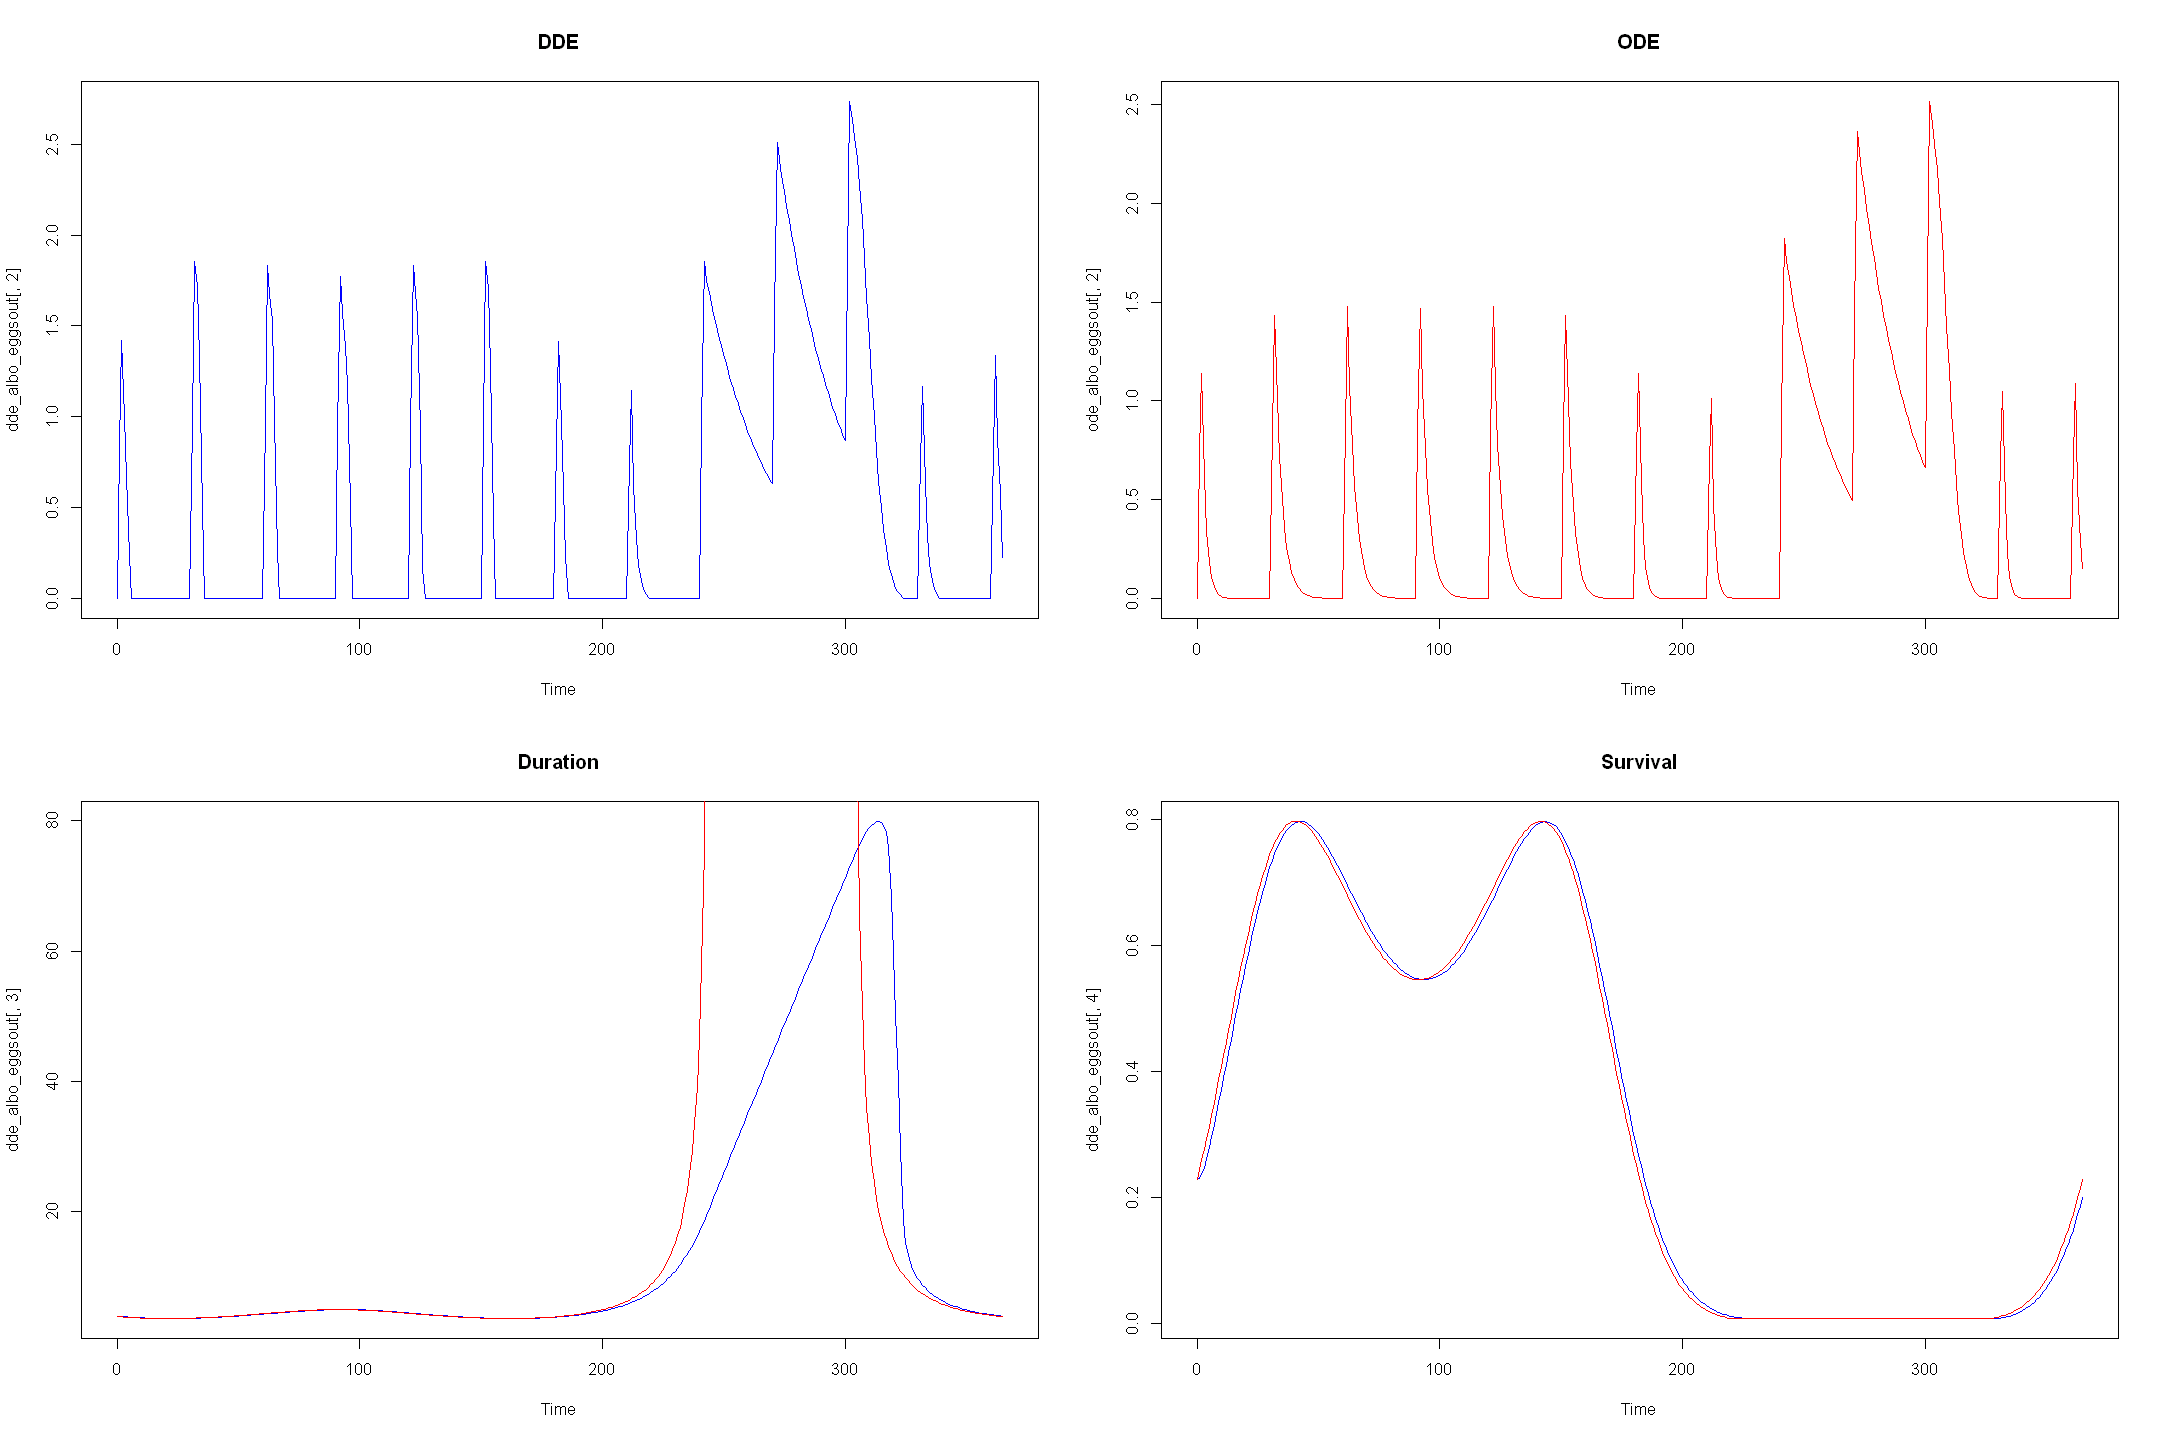

In [9]:
mod = 1 # Scaling factor for stage duration

#Sinusoidal temperature function
Temp <- function(t){
  if(t < 0){
 15 * sin( (2 * pi * 0)/( 365)) + 15
  }else{
    15 * sin( (2 * pi * t)/( 365)) + 15
    
  }
}
y0[numb_E] = 0
y0[numb_t_E] = tau_E(Temp(0))
y0[numb_P_E] = exp(-tau_E(Temp(0)) * delta_E(Temp(0)))
lags[numb_E] = 0
lags[numb_t_E] = tau_E(Temp(0))
lags[numb_P_E] = exp(-tau_E(Temp(0)) * delta_E(Temp(0)))

ode_albo_eggsout <- dde(y0, times, ode_albo_eggs, tol = 1e-6,hbsize = 1000000)
dde_albo_eggsout <- dde(y0, times, dde_albo_eggs, tol = 1e-6, hbsize = 1000000)

par(mfrow = c(2,2))
plot(dde_albo_eggsout[,1],dde_albo_eggsout[,2],type = "l",
     xlab = "Time",main = "DDE",col = "blue")
plot(ode_albo_eggsout[,1],ode_albo_eggsout[,2],type = "l",
     xlab = "Time",main = "ODE",col = "red")
plot(dde_albo_eggsout[,1],dde_albo_eggsout[,3],type = "l",
     xlab = "Time",main = "Duration",col = "blue") + 
  lines(dde_albo_eggsout[,1], 1/mapply(g_E,mapply(Temp,dde_albo_eggsout[,1])),type = "l",col = "red")
plot(dde_albo_eggsout[,1],dde_albo_eggsout[,4],type = "l",
     xlab = "Time",main = "Survival",col = "blue")+ 
  lines(dde_albo_eggsout[,1], mapply(P_E,mapply(Temp,dde_albo_eggsout[,1])),type = "l",col = "red")



As before we now extend the model to include multiple stages (Eggs, Larvae, Pupae, Adults), all of which have different roughly mosquito-like stage durations and survivals. Note that to recall the state of the system at previous times we now have to embed delays within other delays. For example, if we wanted to know how many adults were in the system one generation ago the delay term is expressed  $$A(t - \tau_P(t) - \tau_L(t - \tau_P(t)) - \tau_E(t - \tau_L(t - \tau_P(t)))$$ this sort of delay term can quickly become unwieldy so it's important to ensure your code is structured in a way that allows you to recall these past states accurately.

integer(0)

integer(0)

integer(0)

integer(0)

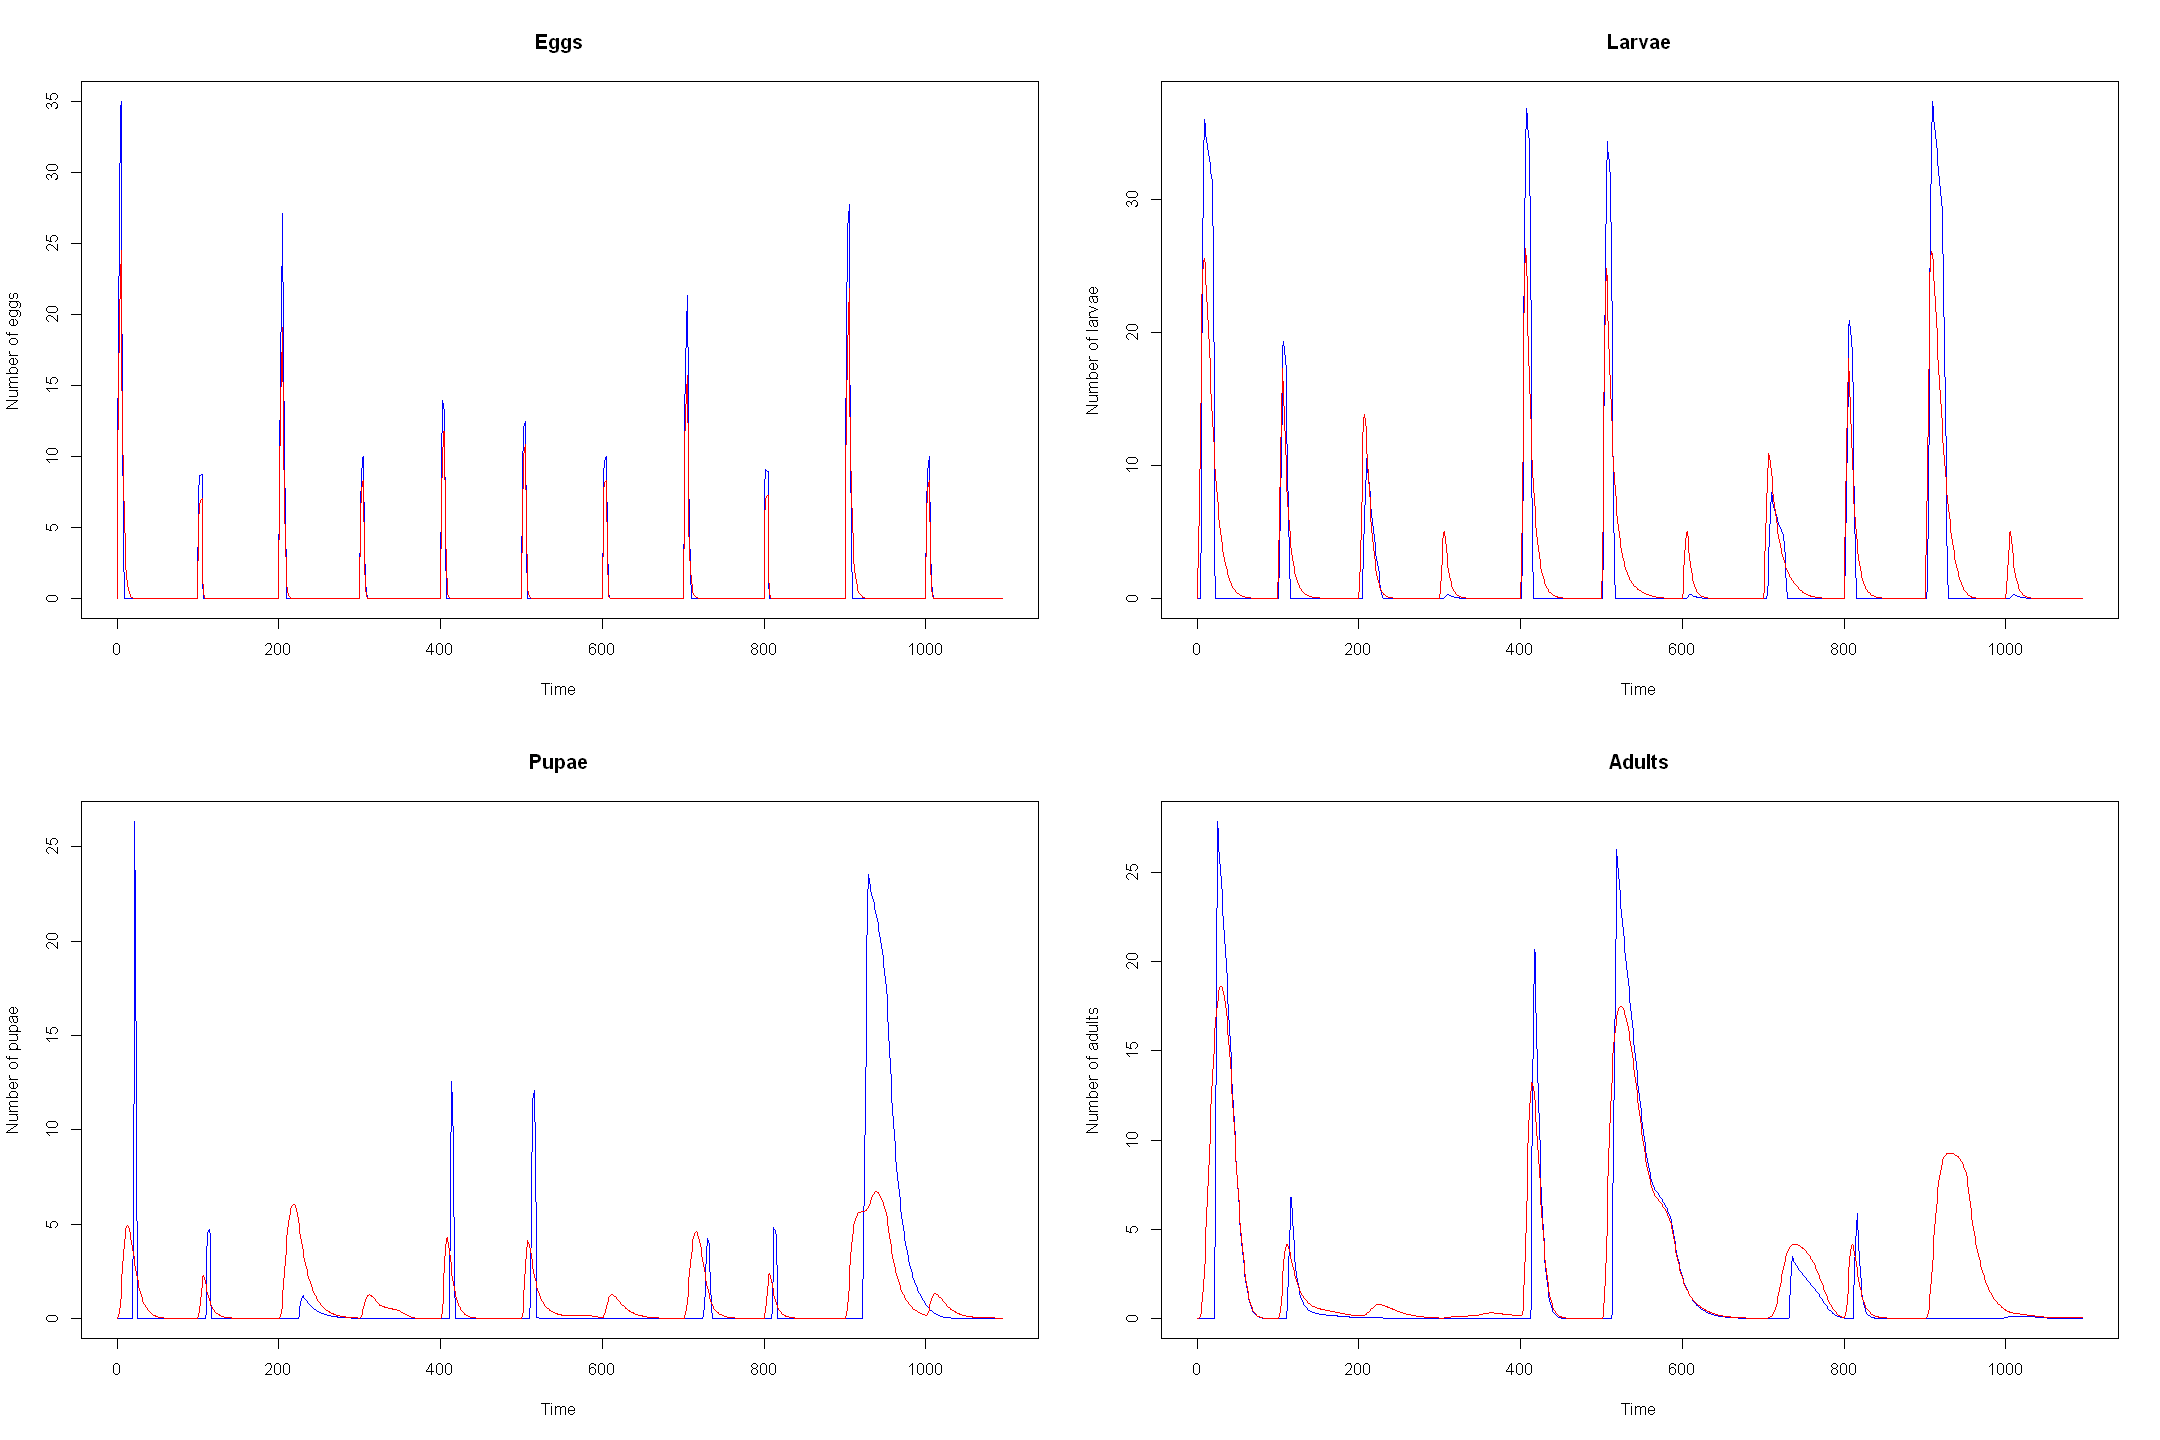

In [10]:
## Multi-stage temperature sensitive model

times = c(0:365)
Temp <- function(t){
  if(t < 0){
 15 * sin( (2 * pi * 0)/( 365)) + 15
  }else{
    15 * sin( (2 * pi * t)/( 365)) + 15
    
  }
}

numb_E = 1; numb_t_E = 2; numb_P_E = 3
numb_L = 4; numb_t_L = 5; numb_P_L = 6
numb_P = 7; numb_t_P = 8; numb_P_P = 9
numb_A = 10; 

y0 <- rep(0,10)
lags <- rep(0,10)
derivs <- rep(0,10)

g_E <- function(TEMP){
    if(TEMP > 32.8){
        out = 0.000551      * 32.8 * (32.8- 9.329449 ) * (35.136607  - 32.8) ^ (1/2 )
    }else if(TEMP < 15){
        out = 0.000551 *15 * (15 - 9.329449) * (35.136607 - 15) ^ (1/2 )
    }else{
        out = 0.000551  * TEMP * (TEMP - 9.329449 ) * (35.136607  - TEMP) ^ (1/2 )
    }
    return(out)
}

#Length of egg stage

tau_E <- function(Temp){

out = 1/g_E(Temp)

return(out)
}

#Through egg stage survival

P_E <- function(TEMP){

  out = -0.00477 * TEMP^2 +  0.19501 * TEMP -1.15303  
  
    if(out > 0.99){
      out = 0.99
    }else if(out < 0.001){
      out = 0.001
    }

return(out)
}

#Active egg mortality rate

delta_E <- function(Temp){

      del = -log(P_E(Temp)) / tau_E(Temp)
    if(del > 0.99){
        del = 0.99
    }

return(del)
}

###Pupal parameters###

#Pupal development rate

g_P <- function(TEMP){

    if(TEMP > 32.0){
    out = 0.000418     * 32.0 * (32.0- 9.560770 ) * (35.272939  - 32.0) ^ (1/2 )
    }else if(TEMP < 10){
    out = 0.000418  *10 * (10- 9.560770 ) * (35.272939 - 10) ^ (1/2 )
    }else{
      out = 0.000418 * TEMP * (TEMP -9.560770) * (35.272939 - TEMP) ^ (1/2 )
    }

    return(out)
}
#Pupal development time

tau_P <- function(TEMP){

  tau = 1/g_P(TEMP)

  return(tau)
}

#Through pupal-stage survival

P_P <- function(TEMP){

    out =   -0.0038 * TEMP^2 +0.1605 * TEMP -0.7539
    
    if(out > 0.99){
    out = 0.99
    }else if(out < 0.001){
    out = 0.001
    }


return(out)
}

#Pupal mortality rate

delta_P <- function(Temp){

    del = (- log(P_P(Temp))/(1 / g_P(Temp)))
    if(del > 0.5){
      del = 0.5
    }

    return(del)
}

###Larval parameters###

#Larval development rate

g_L <- function(TEMP){

  if(TEMP > 35.0){
     out =6.49e-05 * 35.9 * (35- 4.5 ) * (35.4  - 35.0) ^ (1/2 )
   }else if(TEMP < 10){
     out = 6.49e-05  *10 * (10- 4.5) * (35.4 - 10) ^ (1/2 )
   }else{
     out = 6.49e-05* TEMP * (TEMP - 4.5) * (35.4 - TEMP) ^ (1/2 )
   }


  out = ifelse(out < 1/20,1/20,out)
  return(out)
}

tau_L <- function(TEMP){
  
  tau = 1/g_L(TEMP)
  
  return(tau)
}

#Through larval-stage survival

P_L <- function(TEMP){

  if(TEMP < 6){
    out =    -0.00288  *6^2  + 0.13114* 6  -0.62373 
  }else if(TEMP > 40){
    out =     -0.00288 * 40^2 + 0.13114 * 40  -0.62373 
  }else{
   out =    -0.00288  * TEMP^2 + 0.13114 * TEMP  -0.62373 
  }

  return(out)
}

#The biotic component of larval mortality, from temperature and copmetition
delta_L <- function(Temp){

del = (- log(P_L(Temp))/(1 / g_L(Temp)))
if(del > 0.99){
del = 0.99
}

return(del)
}



impulse <- function(t){
  if((t %% 100) > 0 && (t %%100)  <= 5){
    10
  }else{
    0 
  }
}

delta_A <- delta_P

y0[numb_t_E] = tau_E(Temp(0))
y0[numb_t_L] = tau_L(Temp(0))
y0[numb_t_P] = tau_P(Temp(0))
y0[numb_P_E] = exp(-tau_E(Temp(0)) * delta_E(Temp(0)))
y0[numb_P_L] = exp(-tau_L(Temp(0)) * delta_L(Temp(0)))
y0[numb_P_P] = exp(-tau_P(Temp(0)) * delta_P(Temp(0)))
lags =y0

times = c(0:1095)

ode_albo_impulse  <- function(t, y){
  
  TEMP_NOW = Temp(t)
  
  derivs[numb_E]   <-  impulse(t) -  g_E(TEMP_NOW) * y[numb_E] - delta_E(TEMP_NOW) * y[numb_E] 
  derivs[numb_L]   <-  g_E(TEMP_NOW) * y[numb_E] -  g_L(TEMP_NOW) * y[numb_L] - delta_L(TEMP_NOW) * y[numb_L] 
  derivs[numb_P]   <-  g_L(TEMP_NOW) * y[numb_L] -  g_P(TEMP_NOW) * y[numb_P] - delta_P(TEMP_NOW) * y[numb_P] 
  derivs[numb_A]   <-  g_P(TEMP_NOW) * y[numb_P]                              - delta_A(TEMP_NOW) * y[numb_A] 
  
  return(derivs)
}

dde_albo_impulse  <- function(t, y){
  
  if(t - y[numb_t_E]                                          <= 0){ylag_E     <- lags}else{ylag_E     <-  pastvalue(t - y[numb_t_E])}
  if(t - y[numb_t_L]                                          <= 0){ylag_L     <- lags}else{ylag_L     <-  pastvalue(t - y[numb_t_L])}
  if(t - y[numb_t_P]                                          <= 0){ylag_P     <- lags}else{ylag_P     <-  pastvalue(t - y[numb_t_P])}
  if(t - ylag_L[numb_t_E] - y[numb_t_L]                       <= 0){ylag_E_L   <- lags}else{ylag_E_L   <-  pastvalue(t- ylag_L[numb_t_E] - y[numb_t_L])}
  if(t - ylag_P[numb_t_L] - y[numb_t_P]                       <= 0){ylag_L_P   <- lags}else{ylag_L_P   <-  pastvalue(t- ylag_P[numb_t_L] - y[numb_t_P])}
  if(t - ylag_L_P[numb_t_E] - ylag_P[numb_t_L] - y[numb_t_P]  <= 0){ylag_E_L_P <- lags}else{ylag_E_L_P <-  pastvalue(t- ylag_L_P[numb_t_E] - ylag_P[numb_t_L] - y[numb_t_P])}
  
  TEMP_NOW = Temp(t)
  TEMP_E   = Temp(t - y[numb_t_E])
  TEMP_L   = Temp(t - y[numb_t_L])
  TEMP_P   = Temp(t - y[numb_t_P])
  TEMP_E_L   = Temp(t - ylag_L[numb_t_E] - y[numb_t_L])
  TEMP_L_P   = Temp(t - ylag_P[numb_t_L] - y[numb_t_P])
  TEMP_E_L_P = Temp(t - ylag_L_P[numb_t_E] - ylag_P[numb_t_L] - y[numb_t_P])
  
  
  R_E     = impulse(t)
  
  R_E_lag = (g_E(TEMP_NOW) / g_E(TEMP_E))   * impulse(t - y[numb_t_E]) * y[numb_P_E]
  R_L     = (g_E(TEMP_NOW) / g_E(TEMP_E))   * impulse(t - y[numb_t_E]) * y[numb_P_E]
 
  R_L_lag = (g_L(TEMP_NOW)   / g_L(TEMP_L)) * (g_E(TEMP_L)   / g_E(TEMP_E_L)) * 
             impulse(t - ylag_L[numb_t_E] - y[numb_t_L]) * ylag_L[numb_P_E] * y[numb_P_L]
  R_P     = (g_L(TEMP_NOW)   / g_L(TEMP_L)) * (g_E(TEMP_L)   / g_E(TEMP_E_L)) * 
             impulse(t - ylag_L[numb_t_E] - y[numb_t_L]) * ylag_L[numb_P_E] * y[numb_P_L]
  
  R_P_lag = (g_P(TEMP_NOW)   / g_P(TEMP_P)) * (g_L(TEMP_P)   / g_L(TEMP_L_P)) * (g_E(TEMP_L_P) / g_E(TEMP_E_L_P)) * 
             impulse(t - ylag_L_P[numb_t_E] - ylag_P[numb_t_L] - y[numb_t_P]) * ylag_L_P[numb_P_E] * ylag_P[numb_P_L] * y[numb_P_P]
  R_A     = (g_P(TEMP_NOW)   / g_P(TEMP_P)) * (g_L(TEMP_P)   / g_L(TEMP_L_P)) * (g_E(TEMP_L_P) / g_E(TEMP_E_L_P)) * 
             impulse(t - ylag_L_P[numb_t_E] - ylag_P[numb_t_L] - y[numb_t_P]) * ylag_L_P[numb_P_E] * ylag_P[numb_P_L] * y[numb_P_P]
  
  derivs[numb_E]   <-  R_E - R_E_lag - delta_E(TEMP_NOW) * y[numb_E] 
  derivs[numb_L]   <-  R_L - R_L_lag - delta_L(TEMP_NOW) * y[numb_L] 
  derivs[numb_P]   <-  R_P - R_P_lag - delta_P(TEMP_NOW) * y[numb_P] 
  derivs[numb_A]   <-  R_A           - delta_A(TEMP_NOW) * y[numb_A] 
  
  derivs[numb_t_E] <-  1 - (g_E(TEMP_NOW) / g_E(TEMP_E))      
  derivs[numb_t_L] <-  1 - (g_L(TEMP_NOW) / g_L(TEMP_L))      
  derivs[numb_t_P] <-  1 - (g_P(TEMP_NOW) / g_P(TEMP_P))      

  derivs[numb_P_E] <- y[numb_P_E]   * ((g_E(TEMP_NOW)    * delta_E(TEMP_E )) / g_E(TEMP_E)   - delta_E(TEMP_NOW)) 
  derivs[numb_P_L] <- y[numb_P_L]   * ((g_L(TEMP_NOW)    * delta_L(TEMP_L )) / g_L(TEMP_L)   - delta_L(TEMP_NOW)) 
  derivs[numb_P_P] <- y[numb_P_P]   * ((g_P(TEMP_NOW)    * delta_P(TEMP_P )) / g_P(TEMP_P)   - delta_P(TEMP_NOW)) 
  
  return(derivs)
}

par(mfrow = c(2,2))
ode_albo_impulseout <- dde(y0, times, ode_albo_impulse, tol = 1e-6,hbsize = 1000000)
dde_albo_impulseout <- dde(y0, times, dde_albo_impulse, tol = 1e-6, hbsize = 1000000)

plot(dde_albo_impulseout[,1],dde_albo_impulseout[,numb_E+1],type = "l", col = "blue", xlab = "Time",main = "Eggs",ylab = "Number of eggs" ) +
  lines(ode_albo_impulseout[,1],ode_albo_impulseout[,numb_E+1],type = "l", col = "red")
plot(dde_albo_impulseout[,1],dde_albo_impulseout[,numb_L+1],type = "l", col = "blue", xlab = "Time",main = "Larvae",ylab = "Number of larvae" ) +
  lines(ode_albo_impulseout[,1],ode_albo_impulseout[,numb_L+1],type = "l", col = "red")
plot(dde_albo_impulseout[,1],dde_albo_impulseout[,numb_P+1],type = "l", col = "blue", xlab = "Time",main = "Pupae",ylab = "Number of pupae" ) +
  lines(ode_albo_impulseout[,1],ode_albo_impulseout[,numb_P+1],type = "l", col = "red")
plot(dde_albo_impulseout[,1],dde_albo_impulseout[,numb_A+1],type = "l", col = "blue", xlab = "Time",main = "Adults",ylab = "Number of adults" ) +
  lines(ode_albo_impulseout[,1],ode_albo_impulseout[,numb_A+1],type = "l", col = "red")


We now consider a full environmentally sensitive population model for vector dynamics and add back in a renewal process to represent egg laying. This requires us to also consider how the population density is regulated. Initially, we will achieve this by adding a crowding term to the larval mortality rate that will induce high levels of mortality when larval density exceeds an upper limit (don't worry about the dimensions!). 

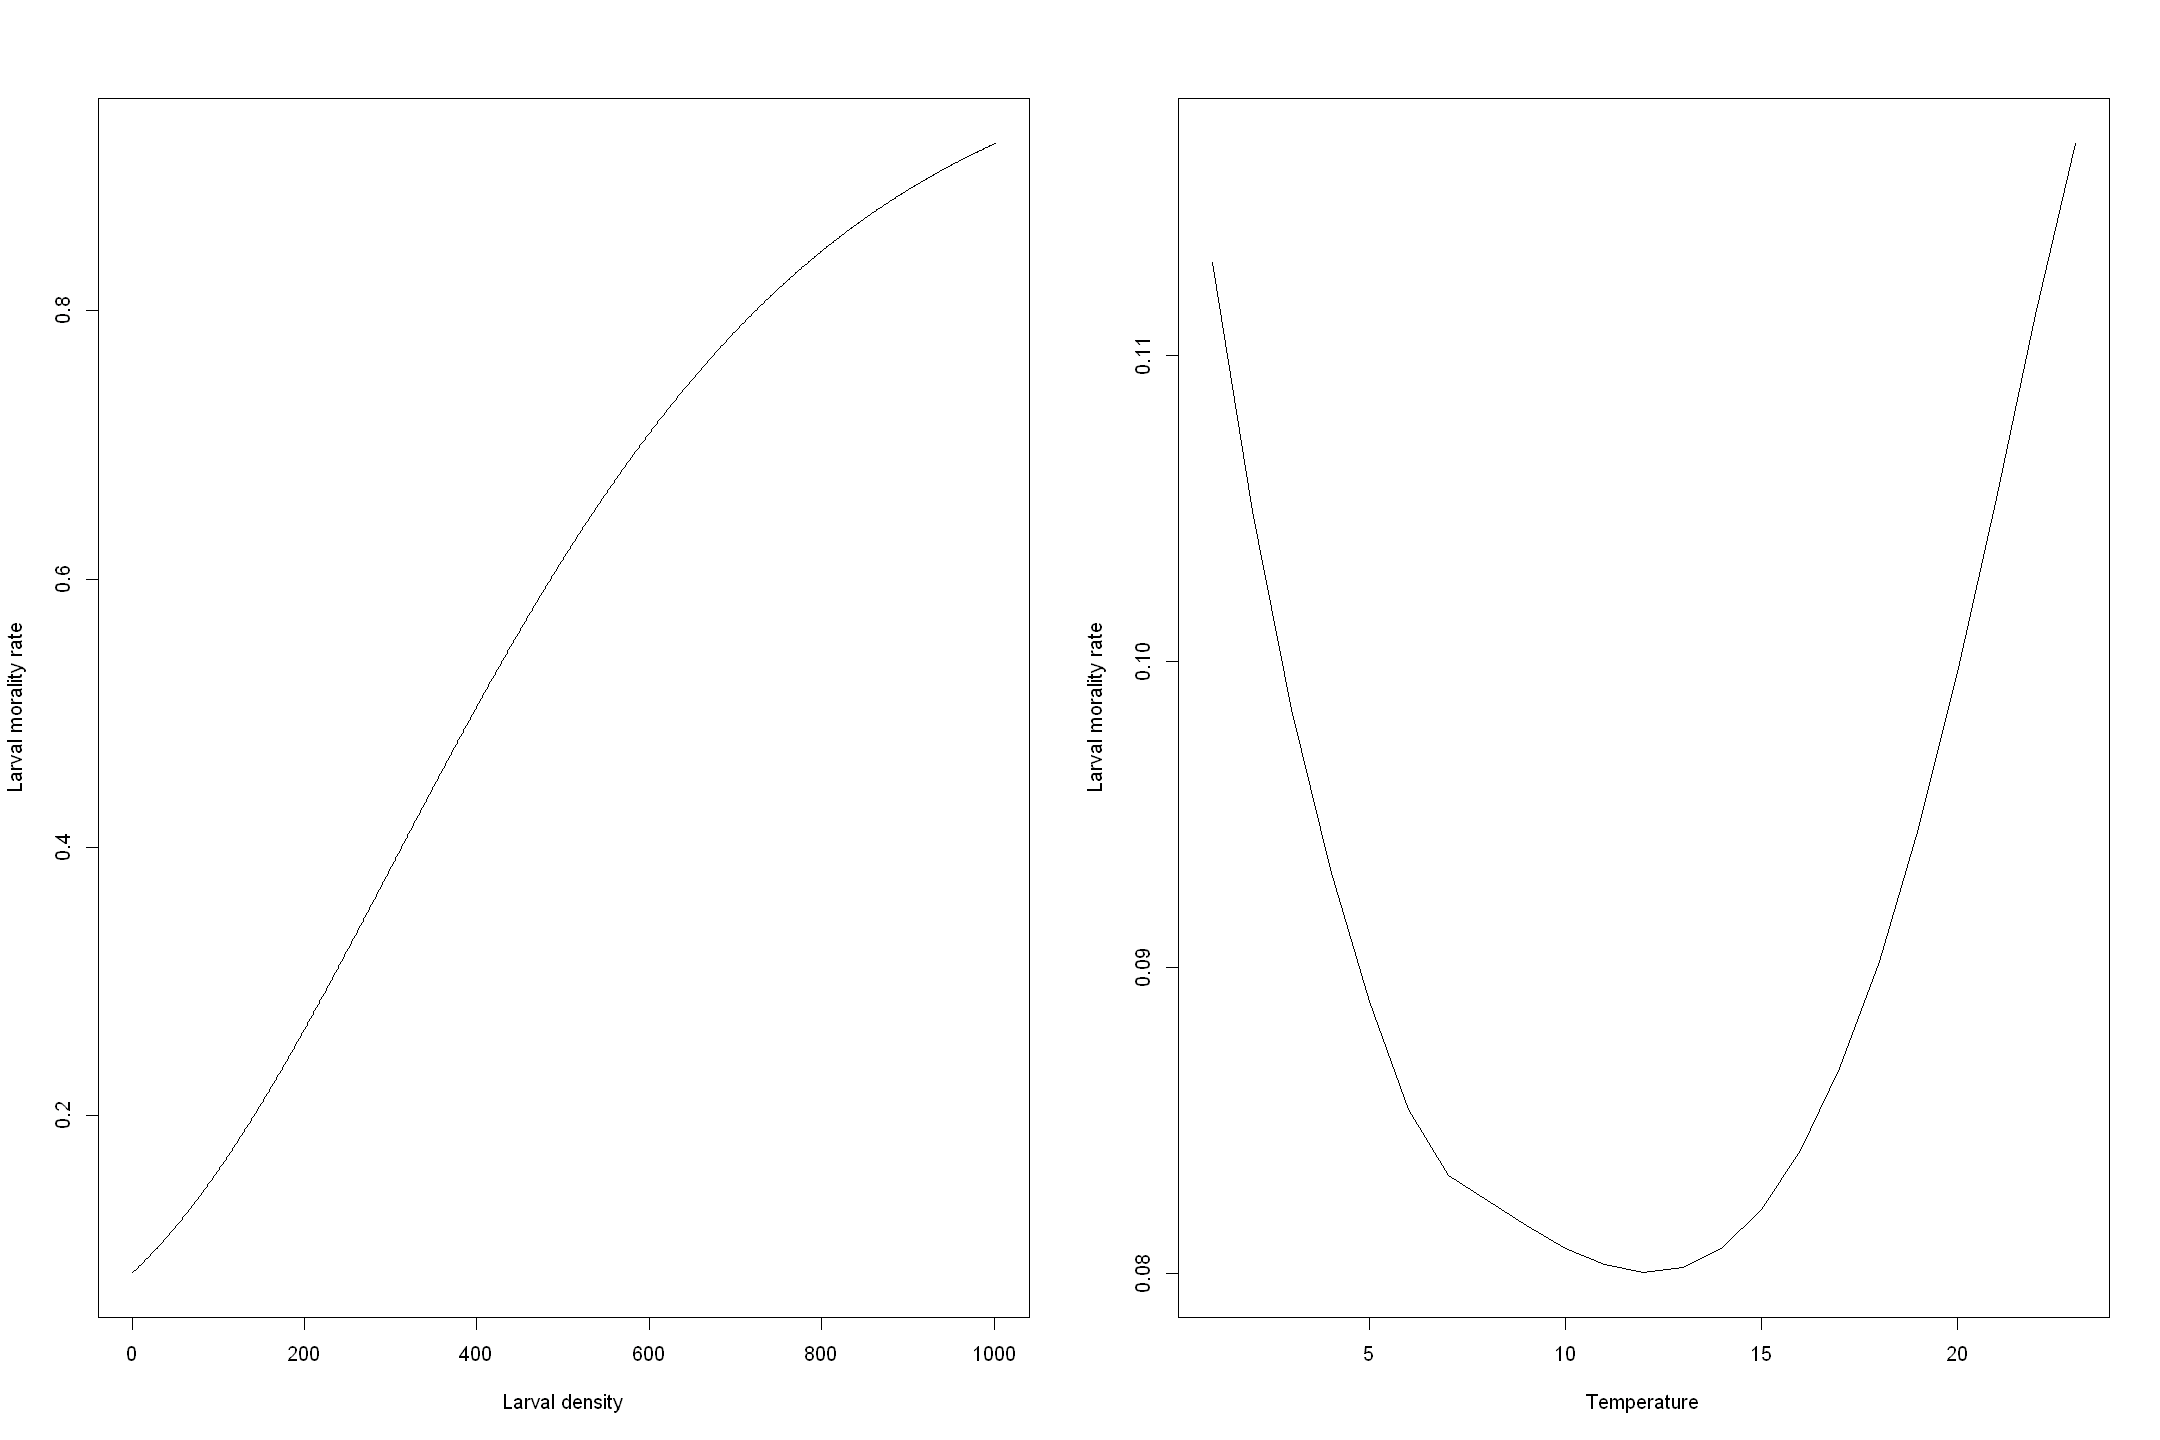

In [11]:
#Culex full mod

delta_L <- function(Temp,Dens){
  
  del = (- log(P_L(Temp))/(1 / g_L(Temp))) + exp(-exp( 1.0-  3.33 * abs(Dens + 1) / 1000))
  if(del > 1){
    del = 1
  }
  
  return(del)
}


par(mfrow = c(1,2))
plot(mapply(delta_L,25,c(0:1000)),type = "l",xlab = "Larval density", ylab = "Larval morality rate")
plot(mapply(delta_L,c(10:32),1),type = "l",xlab = "Temperature", ylab = "Larval morality rate")



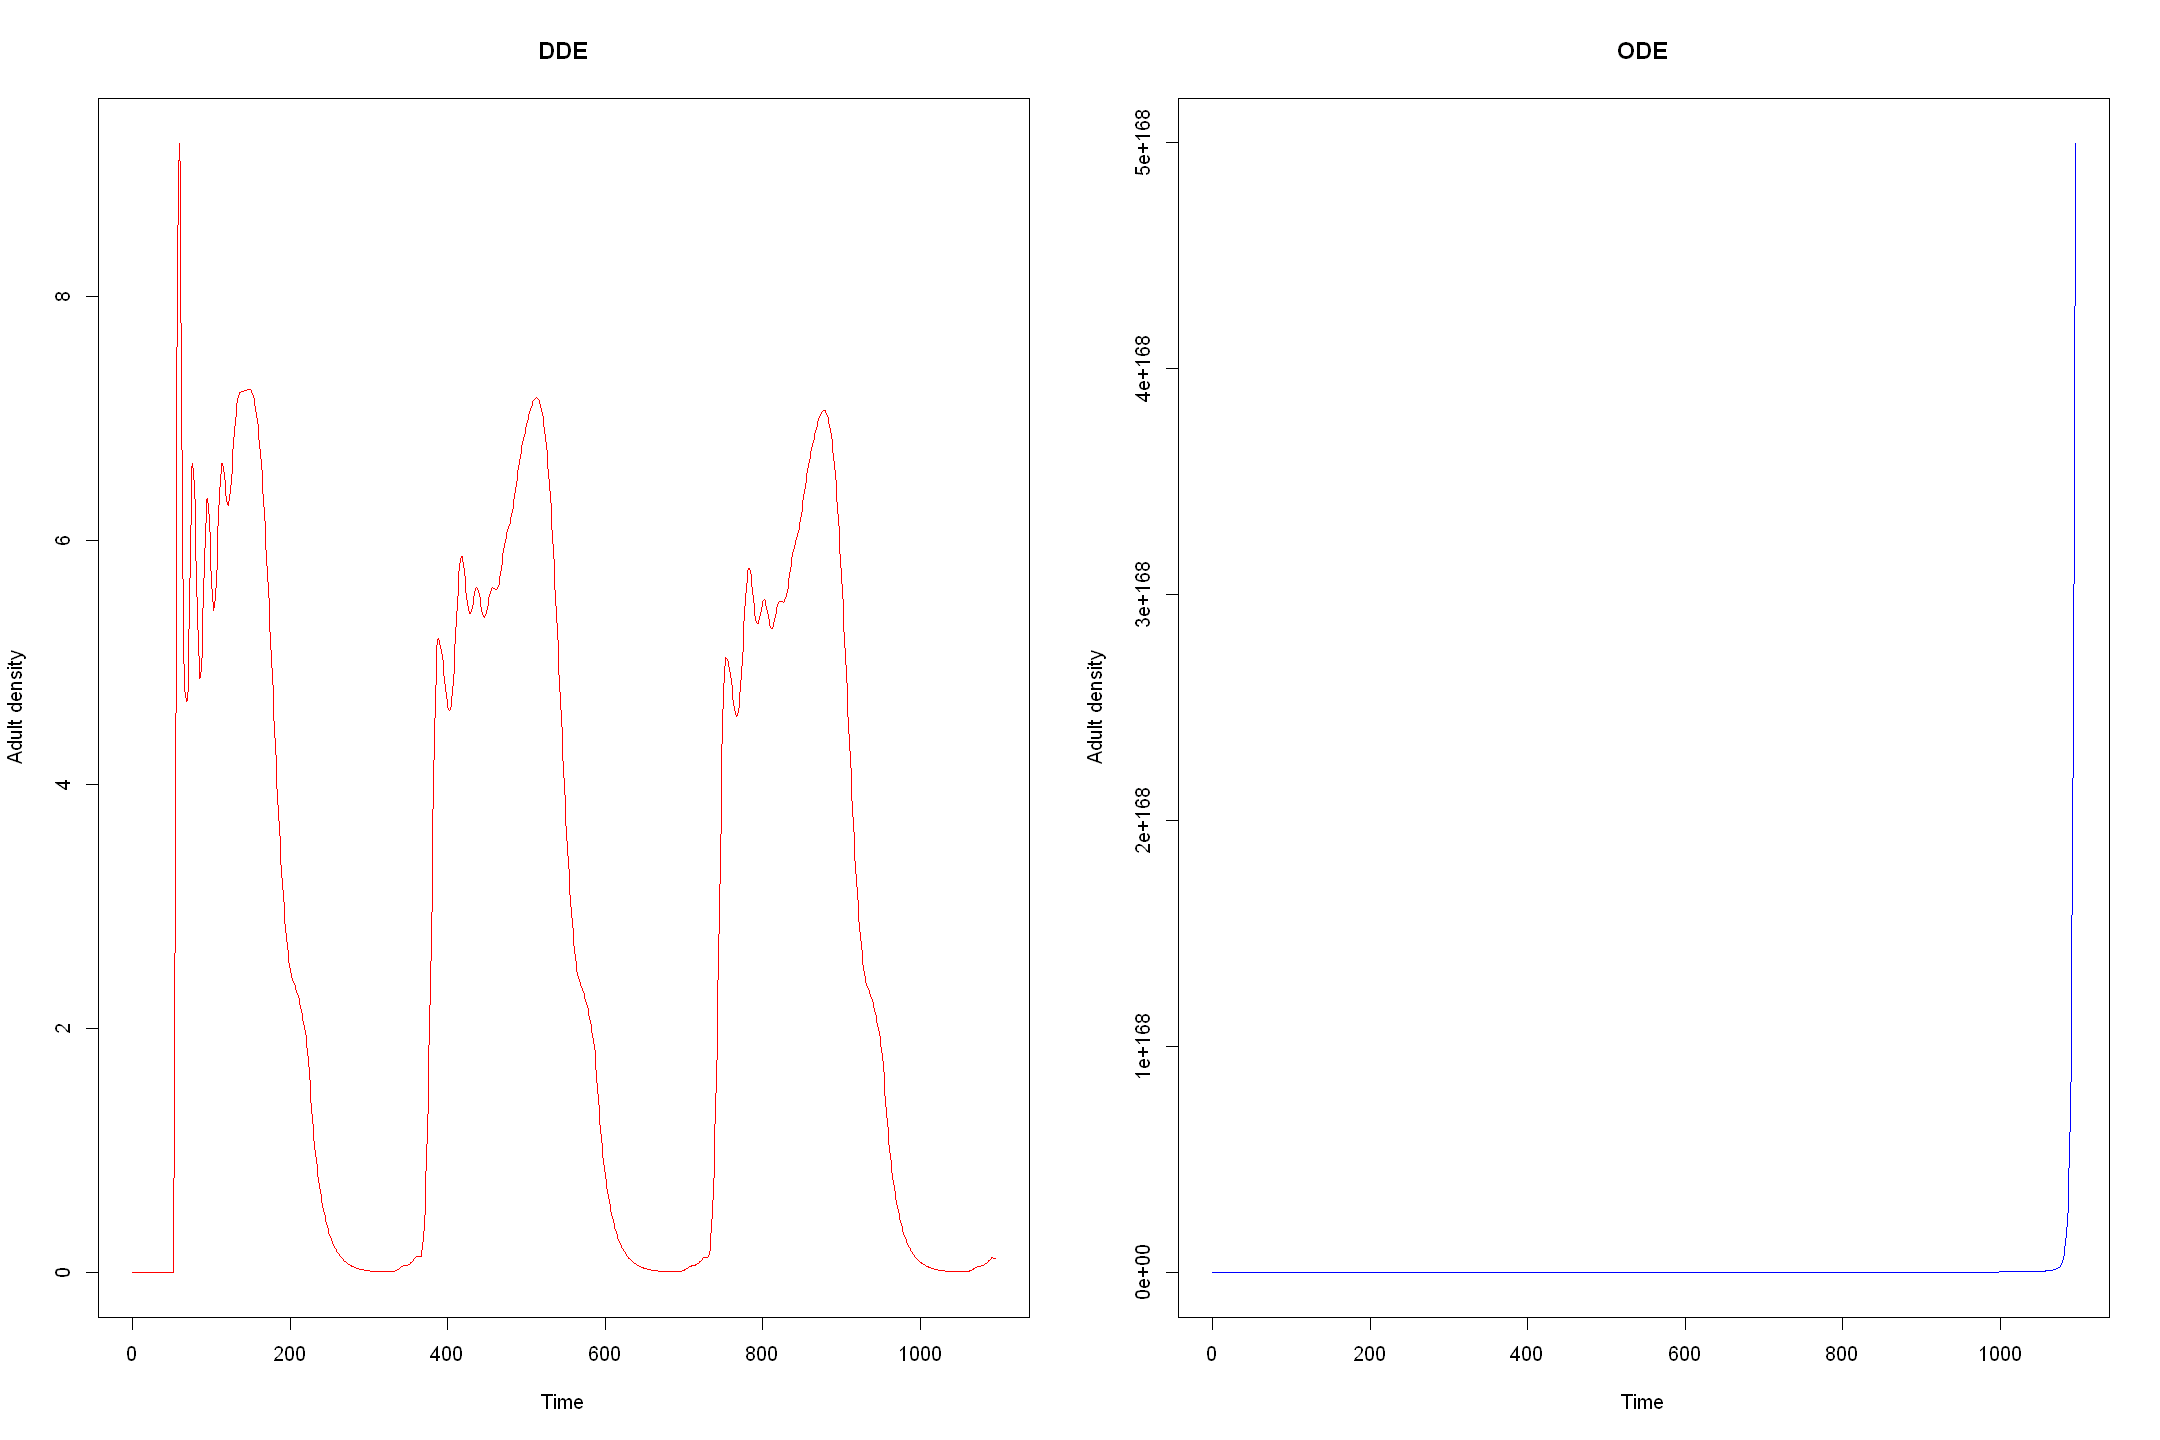

In [12]:
Temp <- function(t){
  if(t < 0){
 15 * sin( (2 * pi * 0)/( 365)) + 15
  }else{
    15 * sin( (2 * pi * t)/( 365)) + 15
    
  }
}

impulse <- function(t){
  if(t > 40 && t   <= 50){
    10
  }else{
    0 
  }
}

delta_A <- delta_P

y0[numb_t_E] = tau_E(Temp(0))
y0[numb_t_L] = tau_L(Temp(0))
y0[numb_t_P] = tau_P(Temp(0))
y0[numb_P_E] = exp(-tau_E(Temp(0)) * delta_E(Temp(0)))
y0[numb_P_L] = exp(-tau_L(Temp(0)) * delta_L(Temp(0),y0[numb_L]))
y0[numb_P_P] = exp(-tau_P(Temp(0)) * delta_P(Temp(0)))

ode_culex_full  <- function(t, y){
  
  TEMP_NOW = Temp(t)
  
  derivs[numb_E]   <-  100 * y[numb_A] + impulse(t) -  g_E(TEMP_NOW) * y[numb_E] - delta_E(TEMP_NOW)          * y[numb_E] 
  derivs[numb_L]   <-  g_E(TEMP_NOW) * y[numb_E]    -  g_L(TEMP_NOW) * y[numb_L]  - delta_L(TEMP_NOW,y[numb_L]) * y[numb_L]# - y[numb_L] ^2/1000
  derivs[numb_P]   <-  g_L(TEMP_NOW) * y[numb_L]     -  g_P(TEMP_NOW) * y[numb_P] - delta_P(TEMP_NOW)          * y[numb_P] 
  derivs[numb_A]   <-  g_P(TEMP_NOW) * y[numb_P]                                 - delta_A(TEMP_NOW)          * y[numb_A] 
  
  return(derivs)
}

dde_culex_full  <- function(t, y){
  
  if(t - y[numb_t_E]                                          <= 0){ylag_E     <- lags}else{ylag_E     <-  pastvalue(t - y[numb_t_E])}
  if(t - y[numb_t_L]                                          <= 0){ylag_L     <- lags}else{ylag_L     <-  pastvalue(t - y[numb_t_L])}
  if(t - y[numb_t_P]                                          <= 0){ylag_P     <- lags}else{ylag_P     <-  pastvalue(t - y[numb_t_P])}
  if(t - ylag_L[numb_t_E] - y[numb_t_L]                       <= 0){ylag_E_L   <- lags}else{ylag_E_L   <-  pastvalue(t- ylag_L[numb_t_E] - y[numb_t_L])}
  if(t - ylag_P[numb_t_L] - y[numb_t_P]                       <= 0){ylag_L_P   <- lags}else{ylag_L_P   <-  pastvalue(t- ylag_P[numb_t_L] - y[numb_t_P])}
  if(t - ylag_L_P[numb_t_E] - ylag_P[numb_t_L] - y[numb_t_P]  <= 0){ylag_E_L_P <- lags}else{ylag_E_L_P <-  pastvalue(t- ylag_L_P[numb_t_E] - ylag_P[numb_t_L] - y[numb_t_P])}
  
  TEMP_NOW = Temp(t)
  TEMP_E   = Temp(t - y[numb_t_E])
  TEMP_L   = Temp(t - y[numb_t_L])
  TEMP_P   = Temp(t - y[numb_t_P])
  TEMP_E_L   = Temp(t - ylag_L[numb_t_E] - y[numb_t_L])
  TEMP_L_P   = Temp(t - ylag_P[numb_t_L] - y[numb_t_P])
  TEMP_E_L_P = Temp(t - ylag_L_P[numb_t_E] - ylag_P[numb_t_L] - y[numb_t_P])
  
  
  R_E     = 100 * y[numb_A] + impulse(t)
  
  R_E_lag = (g_E(TEMP_NOW) / g_E(TEMP_E))   * (100 * ylag_E[numb_A] + impulse(t - y[numb_t_E])) * y[numb_P_E]
  R_L     = (g_E(TEMP_NOW) / g_E(TEMP_E))   * (100 * ylag_E[numb_A] + impulse(t - y[numb_t_E])) * y[numb_P_E]
  
  R_L_lag = (g_L(TEMP_NOW)   / g_L(TEMP_L)) * (g_E(TEMP_L)   / g_E(TEMP_E_L)) * (
                  100 * ylag_E[numb_A] +
                  impulse(t - ylag_L[numb_t_E] - y[numb_t_L])) * ylag_L[numb_P_E] * y[numb_P_L]
  R_P     = (g_L(TEMP_NOW)   / g_L(TEMP_L)) * (g_E(TEMP_L)   / g_E(TEMP_E_L)) * (
                  100 * ylag_E_L[numb_A] +
                  impulse(t - ylag_L[numb_t_E] - y[numb_t_L]) )* ylag_L[numb_P_E] * y[numb_P_L]
  
  R_P_lag = (g_P(TEMP_NOW)   / g_P(TEMP_P)) * (g_L(TEMP_P)   / g_L(TEMP_L_P)) * (g_E(TEMP_L_P) / g_E(TEMP_E_L_P)) * (
                    100 * ylag_E_L_P[numb_A] +
                    impulse(t - ylag_L_P[numb_t_E] - ylag_P[numb_t_L] - y[numb_t_P])) * ylag_L_P[numb_P_E] * ylag_P[numb_P_L] * y[numb_P_P]
  R_A     = (g_P(TEMP_NOW)   / g_P(TEMP_P)) * (g_L(TEMP_P)   / g_L(TEMP_L_P)) * (g_E(TEMP_L_P) / g_E(TEMP_E_L_P)) * (
                  100 * ylag_E_L_P[numb_A] +
                  impulse(t - ylag_L_P[numb_t_E] - ylag_P[numb_t_L] - y[numb_t_P])) * ylag_L_P[numb_P_E] * ylag_P[numb_P_L] * y[numb_P_P]
  
  derivs[numb_E]   <-  R_E - R_E_lag - delta_E(TEMP_NOW) * y[numb_E] 
  derivs[numb_L]   <-  R_L - R_L_lag - delta_L(TEMP_NOW,y[numb_L]) * y[numb_L] 
  derivs[numb_P]   <-  R_P - R_P_lag - delta_P(TEMP_NOW) * y[numb_P] 
  derivs[numb_A]   <-  R_A           - delta_A(TEMP_NOW) * y[numb_A] 
  
  derivs[numb_t_E] <-  1 - (g_E(TEMP_NOW) / g_E(TEMP_E))      
  derivs[numb_t_L] <-  1 - (g_L(TEMP_NOW) / g_L(TEMP_L))      
  derivs[numb_t_P] <-  1 - (g_P(TEMP_NOW) / g_P(TEMP_P))      
  
  derivs[numb_P_E] <- y[numb_P_E]   * ((g_E(TEMP_NOW)    * delta_E(TEMP_E )) / g_E(TEMP_E)   - delta_E(TEMP_NOW)) 
  derivs[numb_P_L] <- y[numb_P_L]   * ((g_L(TEMP_NOW)    * delta_L(TEMP_NOW,ylag_L[numb_L])) / g_L(TEMP_L)   - delta_L(TEMP_NOW,y[numb_L])) 
  derivs[numb_P_P] <- y[numb_P_P]   * ((g_P(TEMP_NOW)    * delta_P(TEMP_P )) / g_P(TEMP_P)   - delta_P(TEMP_NOW)) 
  
  return(derivs)
}

par(mfrow = c(1,2))
ode_culex_fullout <- dde(y0, times, ode_culex_full, tol = 1e-6,hbsize = 1000000)
dde_culex_fullout <- dde(y0, times, dde_culex_full, tol = 1e-6, hbsize = 1000000)

plot(dde_culex_fullout[,1],dde_culex_fullout[,11],type = "l", col = "red" ,main = "DDE",xlab = "Time", ylab = "Adult density") 
plot(ode_culex_fullout[,1],ode_culex_fullout[,11],type = "l", col = "blue" ,main = "ODE",xlab = "Time", ylab = "Adult density") 


The previous example is somewhat silly as ODE models often account for density dependence through different processes such as predation. Uncomment the line of code the term $-L(t)^2/K$ to add "predation" into the ODE model and compare the dynamics, think about the experimental data you might need to parametrise each form of density dependence in a real model.

# Phenotypic plasticity (or carry-over effects) in DDEs

Mosquitoes are affected by larval density dependence instantaneously in the larval stage with increases in mortality and development rates. We can account for both of these using the formulations we have developed in the previous section. However, another effect of larval density dependence is on the traits that adult mosquitoes express, specifically adult survival and  adult fecundity - both important in predicting population and disease dynamics. Thankfully the DDE framework can track the effects of previous density depedendent competition and assign them to cohorts of individuals in the adult stage. As prototypical example of this we return to the previous blowfly model.

Like mosquitoes, blowlfies also experience delayed consequences of larval competition. Blowflies specifically experience higher mortality through pupation and reduced maximum adult fecundity in addition to the effect that competition for adult food has on egg production. To represent this we modify the blowlfy model so that upon pupation we can assign adult blowflies to a cohort of individuals that all express the same trait as determined by that cohorts experience of larval competition, denoted $\alpha(t)$ (see schematic for model structure).

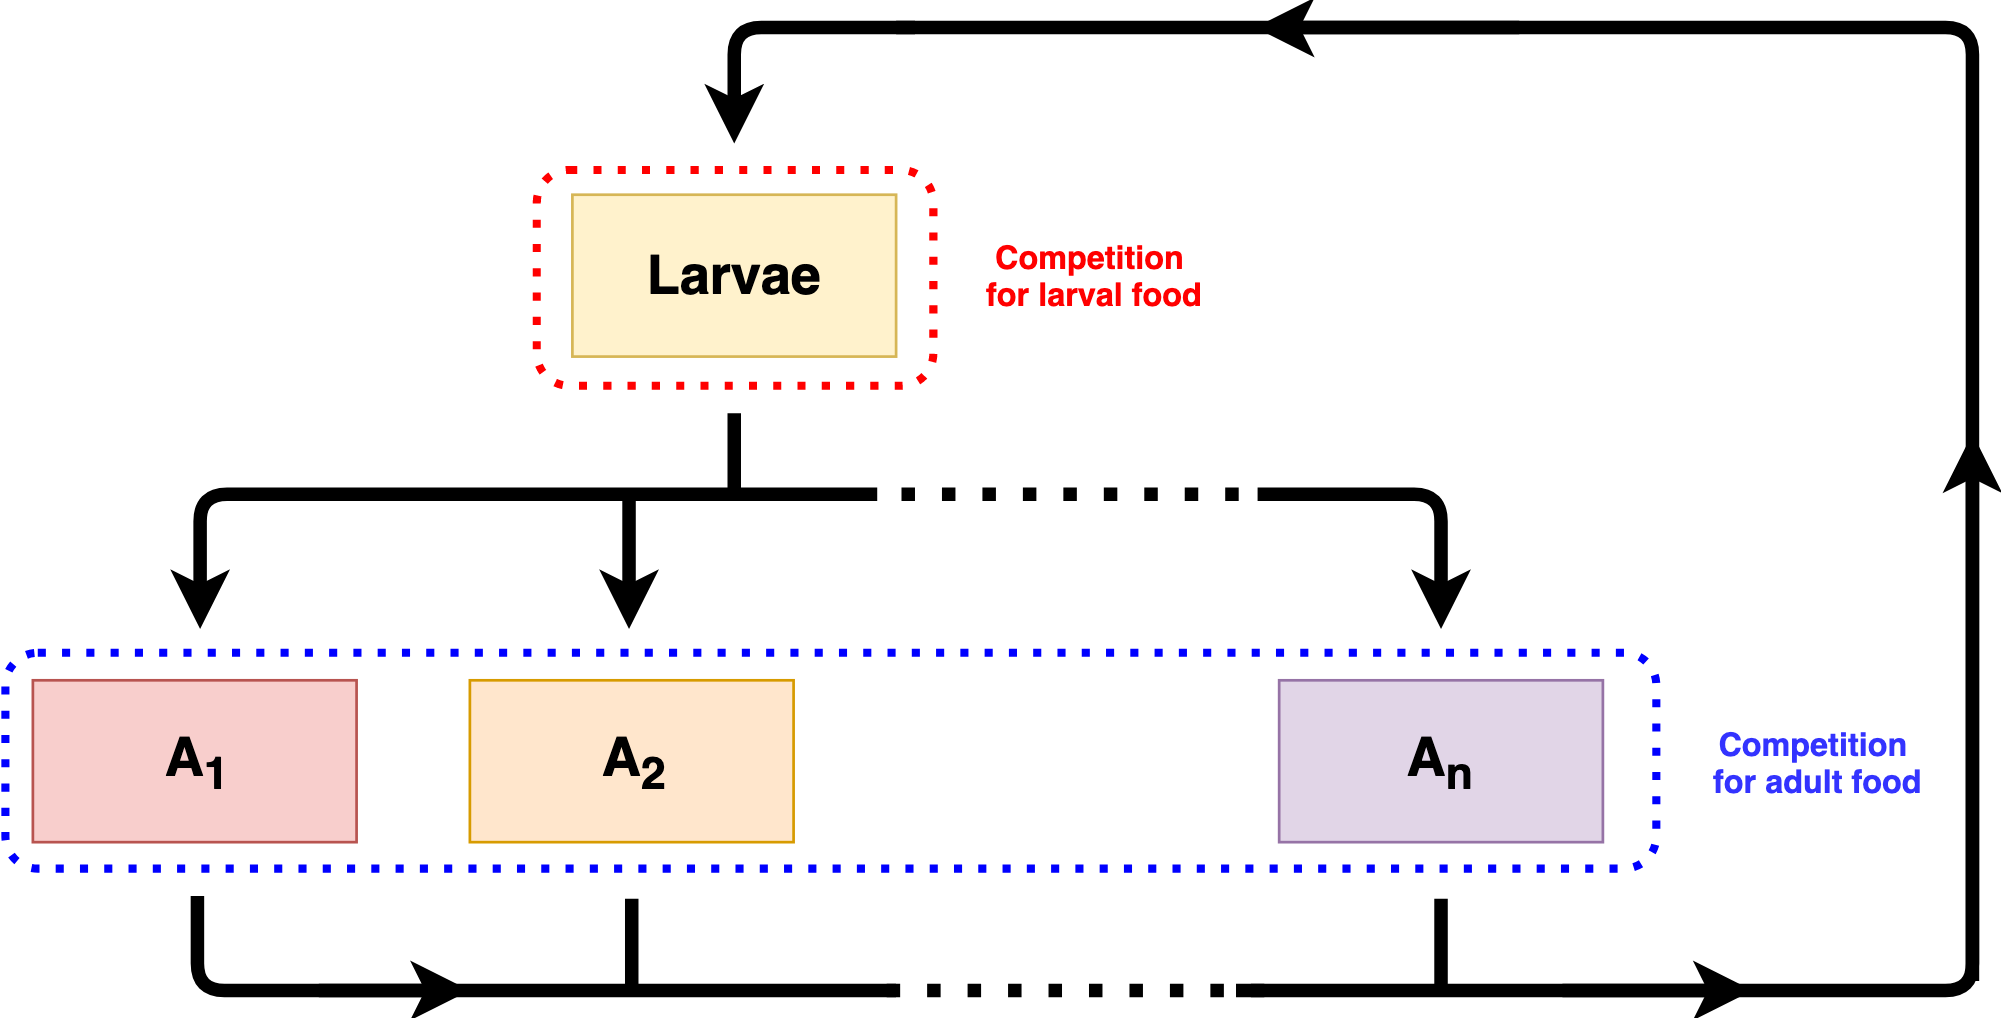

The model takes the form

$$\begin{align}
\frac{dL(t)}{dt} &= R_L(t) - R_L(t-\tau_L)S_L - \delta_LL(t)\\
\frac{dA_j(t)}{dt} &= R_{A_j}(t) - \delta_{A} A_j(t)\,\,\,\, \textrm{for} \,\,\,j \in 1,...,m\\
\frac{d\alpha(t)}{dt} &= \frac{-\alpha^2(t)(L(t) - L(t-\tau_L))}{K_L\tau_L}.
\end{align}$$

Recruitment terms are given by

$$\begin{align}
R_L(t) &= \left[\sum^m_{j=1}q_jA_j(t-\tau_E)e^{-A_{\textrm{Tot}}(t-\tau_E)/K_A} + I(t-\tau_E)\right]S_E\\
R_{A_j}(t) &= \sum^m_{j=1}w_j(\alpha(t - \tau_P - \tau_J))R_L(t-\tau_L-\tau_P-\tau_J)S_LS_{J_j}
\end{align}$$

$\textrm{for} \,\,\,j \in 1,...,m$ where $I(t-\tau_E)$ is an inoculation term that begins the dynamics, and represents the introduction of larvae into the system at $t=0$, and $q_j$ and $S_{J_j}$ are determined by the reaction norms we paramatrise below. These norms show that as larval competition increases we can expect a reduction in adult maximum fecundity and through pupal stage survival.

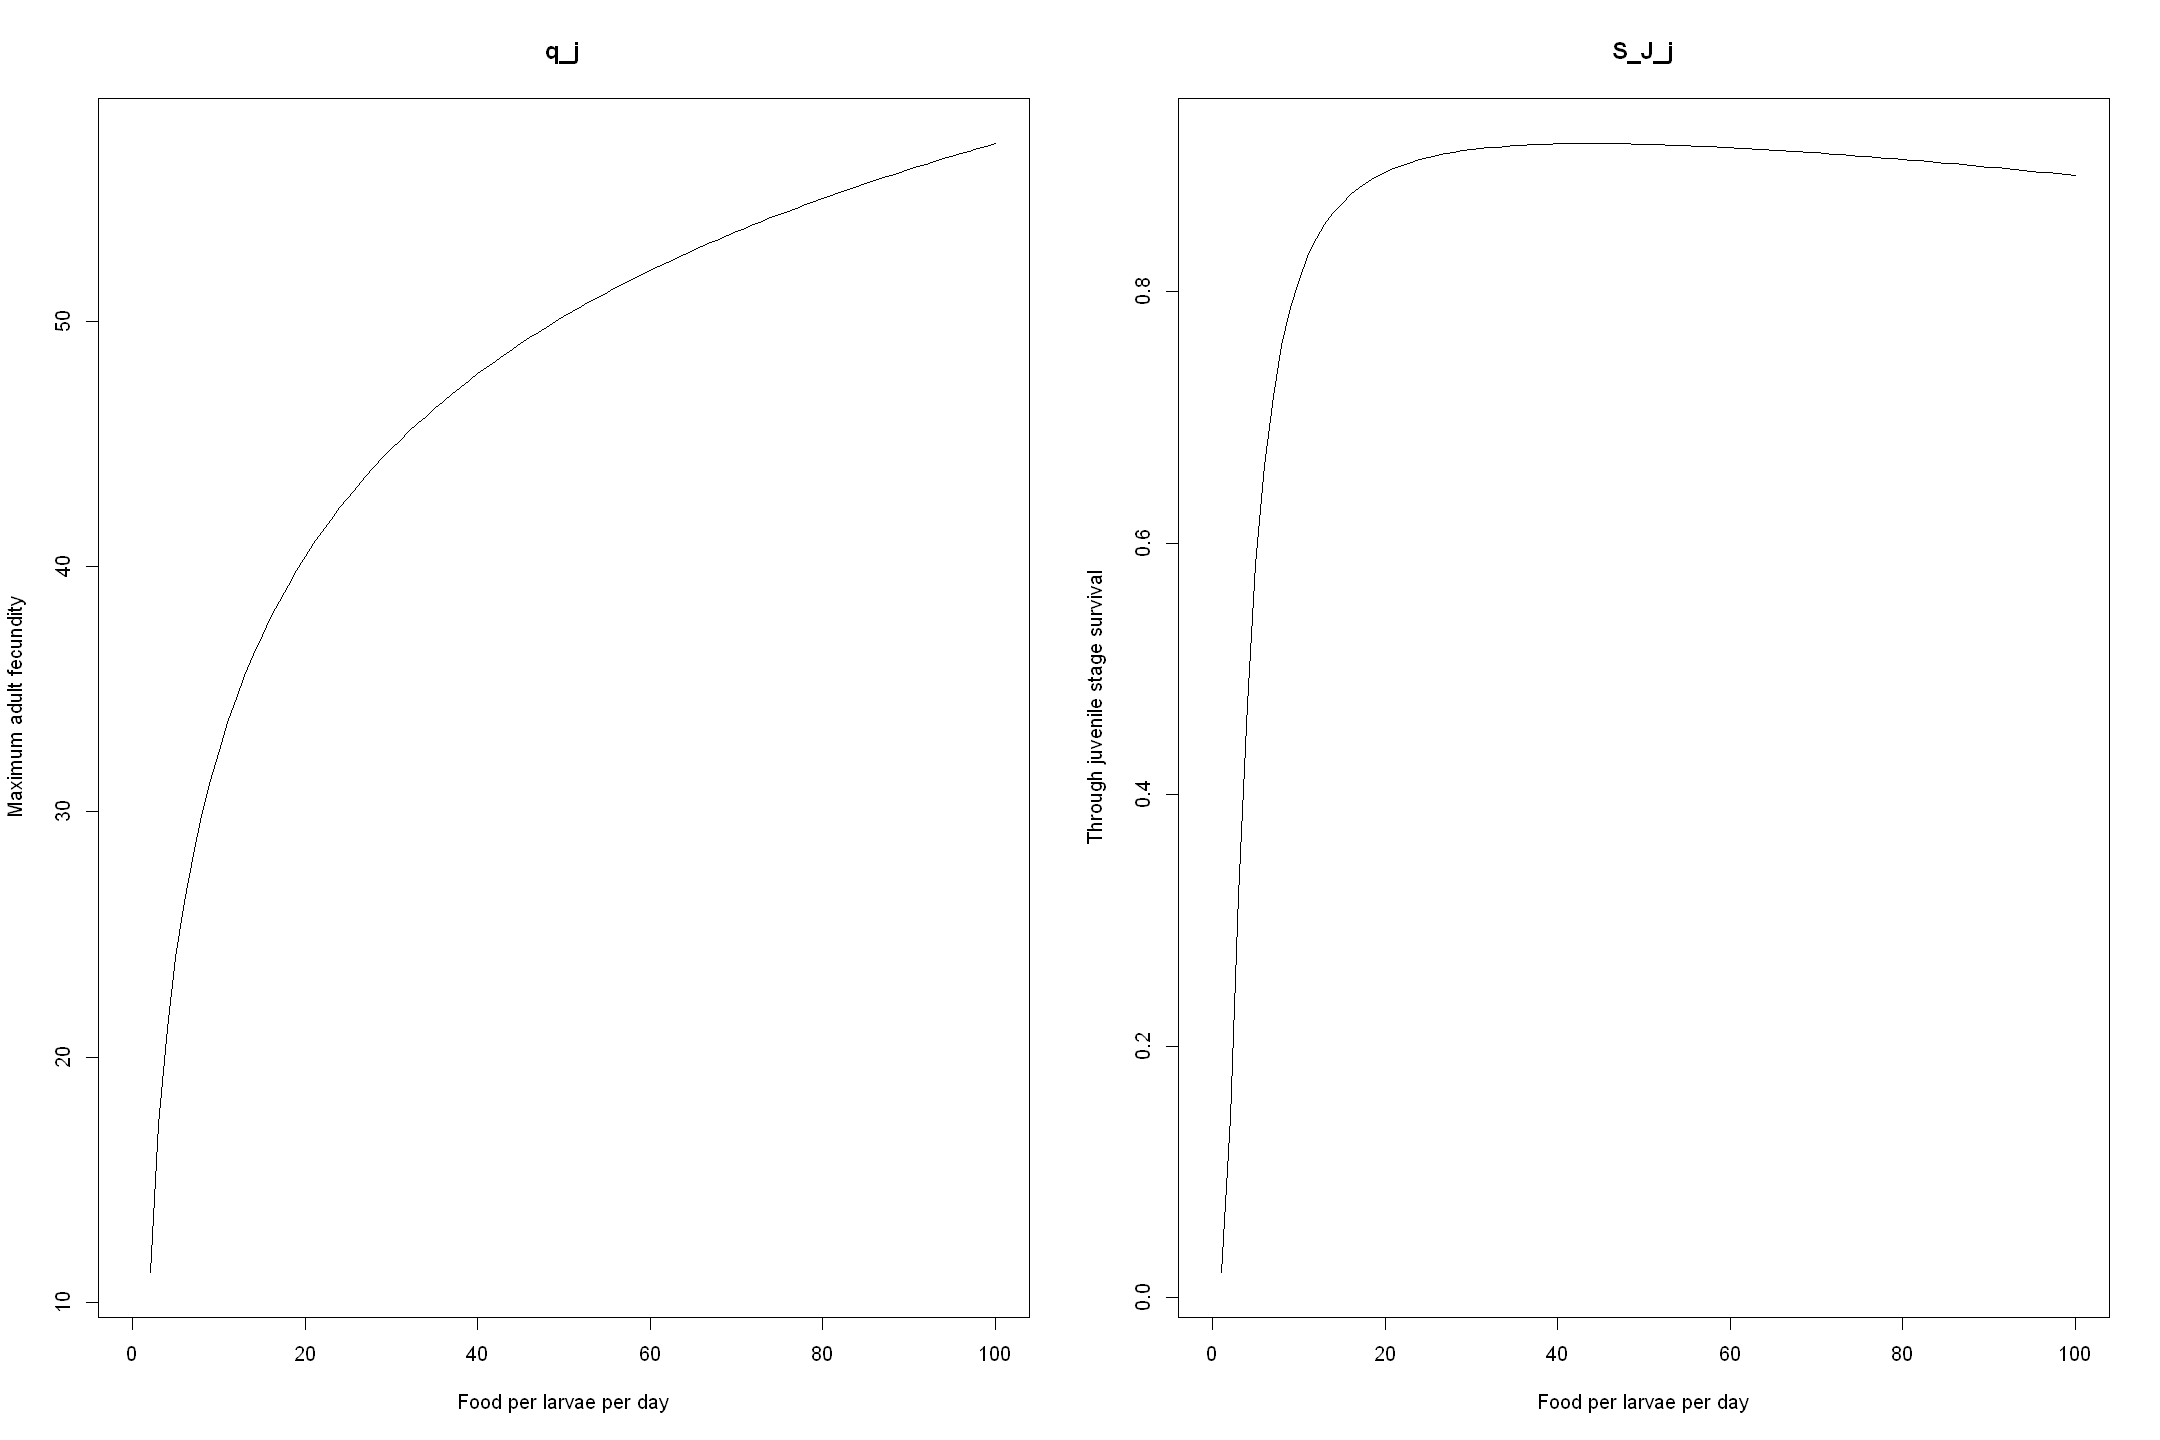

In [13]:
  q_func <- function(x) {
    q_val <-3.95*(6.9*log(x) - 0.97)^0.78
    return(q_val)
  }

  surv_func <- function(x) {
    surv <- (exp(-4+3.36*log(2000/(x))-0.44*log(2000/(x))^2))/(1+exp(-4+3.36*log(2000/(x))-0.44*log(2000/(x))^2))
    return(surv)
  }
par(mfrow = c(1,2))
plot(c(0:100),mapply(q_func,c(0:100)), xlab = "Food per larvae per day",ylab = "Maximum adult fecundity", main = "q_j", type = "l")
plot(c(0:100),mapply(surv_func,c(0:100)), xlab = "Food per larvae per day",ylab = "Through juvenile stage survival",main = "S_J_j",type = "l")


In [14]:
#Phenotypically plastic blowfly model
  

  n = 32                       # Sets number of plastic trait classes that are allowed
  times = seq(0, 1000, 0.01)   #Times to solve for

  L_max = 50000                # Amount of larval food supplied daily
  a_f_1 <- 2000                # Initial adult food supply
  a_f_2 <- 1200                # Subsequent adult food supply
  switch_time = 610            # Time at which food supplies switch (can be made negative or very large to represent a single food condition)

  # Names parameter values for use in model

  parms <-
    list(

      #Names useful numbers
      n = n,
      numb = n + 2,

      #Delays for different life-stages
      tau_E = 0.6,
      tau_L = 5,
      tau_pi = 5.9,
      tau_J = 4.1,

      #Per capita death rates for eggs and larvae
      delta_E = 0.07,
      delta_L = 0.004,

      #Through stage survival#
      P_E = exp(-0.6 * 0.07),
      P_L = exp(-5 * 0.004)
    )


  #Defines the discretisation of the environmental classes
  limits      <- seq(0,4.82, 4.82 / (n - 1))
  limits[n + 1] <- 14
  limits <- exp(limits)
  limits[1] <- 0

  #Defines midpoints of the intervals of the discretised environmental classes
  values <- rep(0, n)

  for (i in 1:n-1) {
    values[i] <- (limits[i] + limits[i + 1]) / 2
  }

  values[n] <- limits[n] + 1/2

  limits <- rev(limits)
  values <- rev(values)

  #Sets adult death rate (This is a vector to allow for potential variation)
  delta = rep(0.27, n)

  #Reaction norm for maximum adult fecundity
  q_func <- function(x) {
    q_val <-3.95*(6.9*log(x) - 0.97)^0.78
    return(q_val)
  }

  #Defines q_j for the environmental classes by evaluating the reaction norm at the midpoints of the discretisation

  q <- q_func(values)

  for(i in 1:length(q)){
    if(is.nan(q[i]) == TRUE){
      q[i] <- 0
    }
    if(q[i] <0){
      q[i] = 0
    }
  }

  if(values[i] < 0.14){
    q[i] <- 0
  }

  #Reaction norm for survival through the combined pupal and juvenile stages

  surv_func <- function(x) {
    surv <- (exp(-4+3.36*log(2000/(x))-0.44*log(2000/(x))^2))/(1+exp(-4+3.36*log(2000/(x))-0.44*log(2000/(x))^2))
    return(surv)
  }

  #Defines P_J_j

  P_J <- c(surv_func(values))

  for(i in 1:length(P_J)){
    if(is.na(P_J[i])){
      P_J[i] <- 0
    }
    if(values[i] < 1.4){
      P_J[i] <- 0
    }

  }

  P_J[n] <- 0
  P_J <- P_J*exp(-0.0025*4.1)


  #Function defined for inital impulse

  on_off <- function(t, a) {
    if (t <= a + 2 && t >= a - 0.2) {
      1
    } else{
      0
    }
  }

  #Initial conditions

  y0 = rep(0, n + 2)
  y0[1] <- 9500
  y0[2] <- L_max/y0[1]

  #Defines the history of delay terms

  lags <- rep(0, n + 2)
  lags[1] <- y0[1]
  lags[2] <- L_max/lags[1]

  #Defines the history of growth terms (R_E etc.)

  hist_growth <- rep(0, length(times))
  derivs <- rep(0, n + 2) #Initialises derivative storage
  w <-rep(0, n)         #Stores the values of W_i that determine recruitment into plastic trait classes
  R_A <- rep(0, n)       #Initialises growth term storage

  limits[1] <- -10000    #Catchall for environmental classes


  #Changes the adult food condition

  adult_food <- function(t,lag){
    if(t - lag < switch_time){
      adult_food_val <- a_f_1
    }else{
      adult_food_val <- a_f_2
    }
    return(adult_food_val)
  }
  #

   #Function defining DDE
  my_grad <- function(t, y, parms) {
    with(as.list(c(parms)), {

      #Defines the time lags for use in future functions.

      tlag <-
        c(
          t - tau_E,
          t - tau_E - tau_L,
          t - tau_E - tau_L - tau_pi,
          t - tau_E - tau_L - tau_pi - tau_J,
          t - tau_J - tau_pi,
          t - tau_L
        )

      #Sets the lag either to 0 if the time lag is still in the initial conditions or to the past value of the parameter if tlag[i] > 0

      ifelse(tlag[1] <= 0, ylag1  <- lags, ylag1  <-  pastvalue(t - tau_E))
      ifelse(tlag[2] <= 0, ylag2  <- lags, ylag2  <-  pastvalue(t - tau_E - tau_L))
      ifelse(tlag[4] <= 0, ylag4  <- lags, ylag4  <-  pastvalue(t - tau_E - tau_L - tau_pi - tau_J))
      ifelse(tlag[5] <= 0, ylag5  <- lags, ylag5  <-  pastvalue(t - tau_J - tau_pi))
      ifelse(tlag[6] <= 0, ylag6  <- lags, ylag6  <-  pastvalue(t - tau_L))

      #Sets the history of the adult class (i.e. adult_E refers to the number of adults tau_E ago)

      adults_E <- ylag1[3:numb]
      adults_L <- ylag2[3:numb]
      adults_J <- ylag4[3:numb]

      #Sums all adults at the lagged time

      sum_adults_E <- sum(ylag1[3:numb])
      sum_adults_L <- sum(ylag2[3:numb])
      sum_adults_J <- sum(ylag4[3:numb])

      #Calculates the total births at a lagged time

      growth_E <- sum(q * adults_E)
      growth_L <- sum(q * adults_L)
      growth_J <- sum(q * adults_J)

      #Computes growth rates at lagged times

      R_E_lag  =   growth_E * exp(-(sum_adults_E)  / adult_food(t,tau_E))   +  on_off(t, tau_E)
      R_L_lag  =  (growth_L * exp(-(sum_adults_L)  / adult_food(t,tau_E + tau_L))   +  on_off(t, tau_E + tau_L)) * P_E
      R_J_lag  =  (growth_J * exp(-(sum_adults_J)  / adult_food(t,tau_E + tau_L + tau_pi + tau_J))   +  on_off(t, tau_E + tau_L + tau_pi + tau_J)) * P_E * P_L


      #Determines which plastic trait class adults are recruited into at time t

      value <- ylag5[2]


      for (i in 1:n) {

        if (limits[i] >= value && value > limits[i + 1]) {
          w[i] = 1
        } else{
          w[i] = 0
        }
      }

      #Computes current larval recruitment

      R_L  = (R_E_lag) * P_E

      #Computes current recruitment of adults into environmental class i

      for (i in 1:n) {
        R_A[i] =  (w[i]) * R_J_lag  * P_J[i]
      }

      #Defines derivatives

      derivs[1] <- R_L  - R_L_lag  * P_L  - delta_L  * y[1]  #Change in larval population
      derivs[2] <- -y[2]^2*((y[1] - ylag6[1]))/(L_max*tau_L)               #Change in average larval density over the period from
      derivs[3:(n+2)] <- R_A[1:n]  - delta[1:n]  * y[3:(n+2)]          #Change in adult population over plastic trait classes i

      return(derivs)                                         #Returns the vector of derivatives
    })
  }


Nicholson ran a different cage experiment with same flies where after almost two years(!) supplying the adult population with unlimited food he reduced the food supply (results replicated in the graph below). What's strange about the behaviour we observe? 

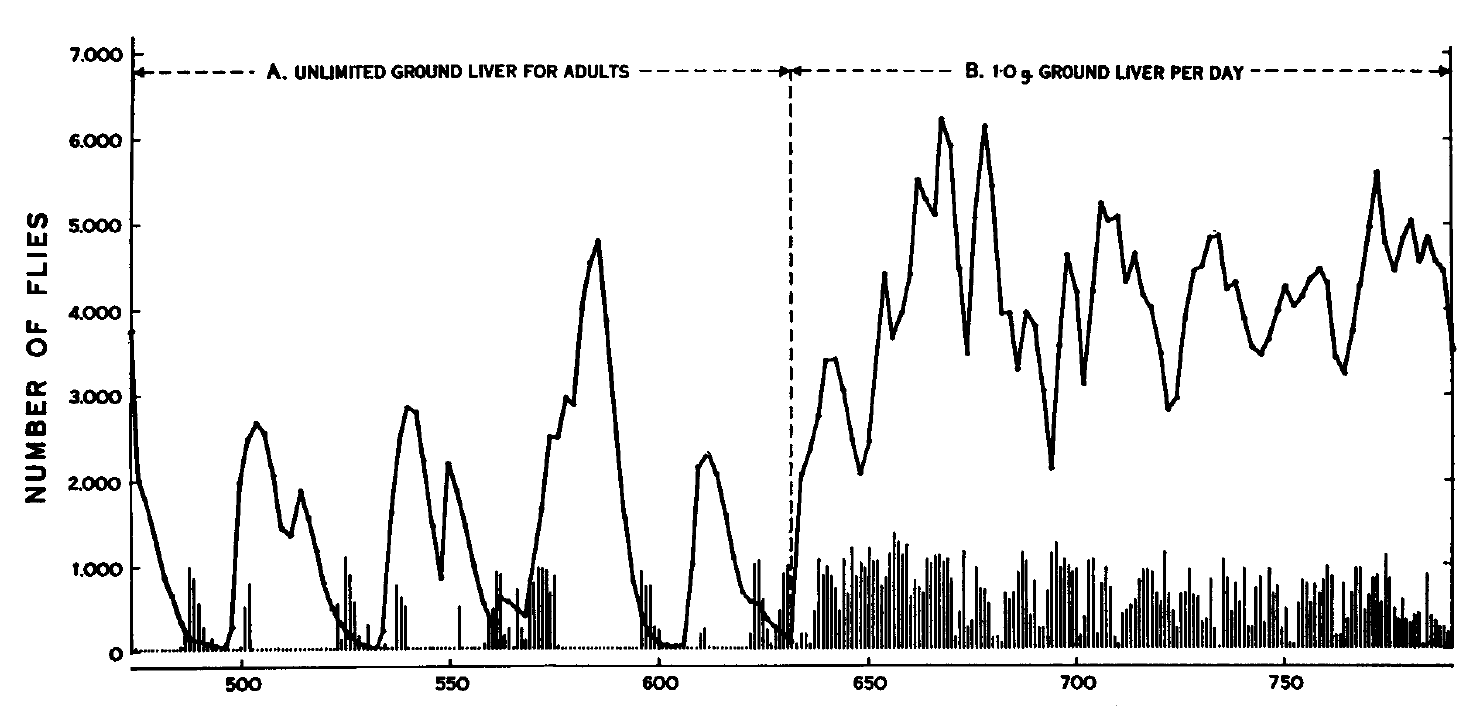

We set up the blowlfy model to replicate the switch in adult food supplies, try running the model (this will take longer than the previous models). Play around with the food before and after the switch to see what other dynamics emerge.

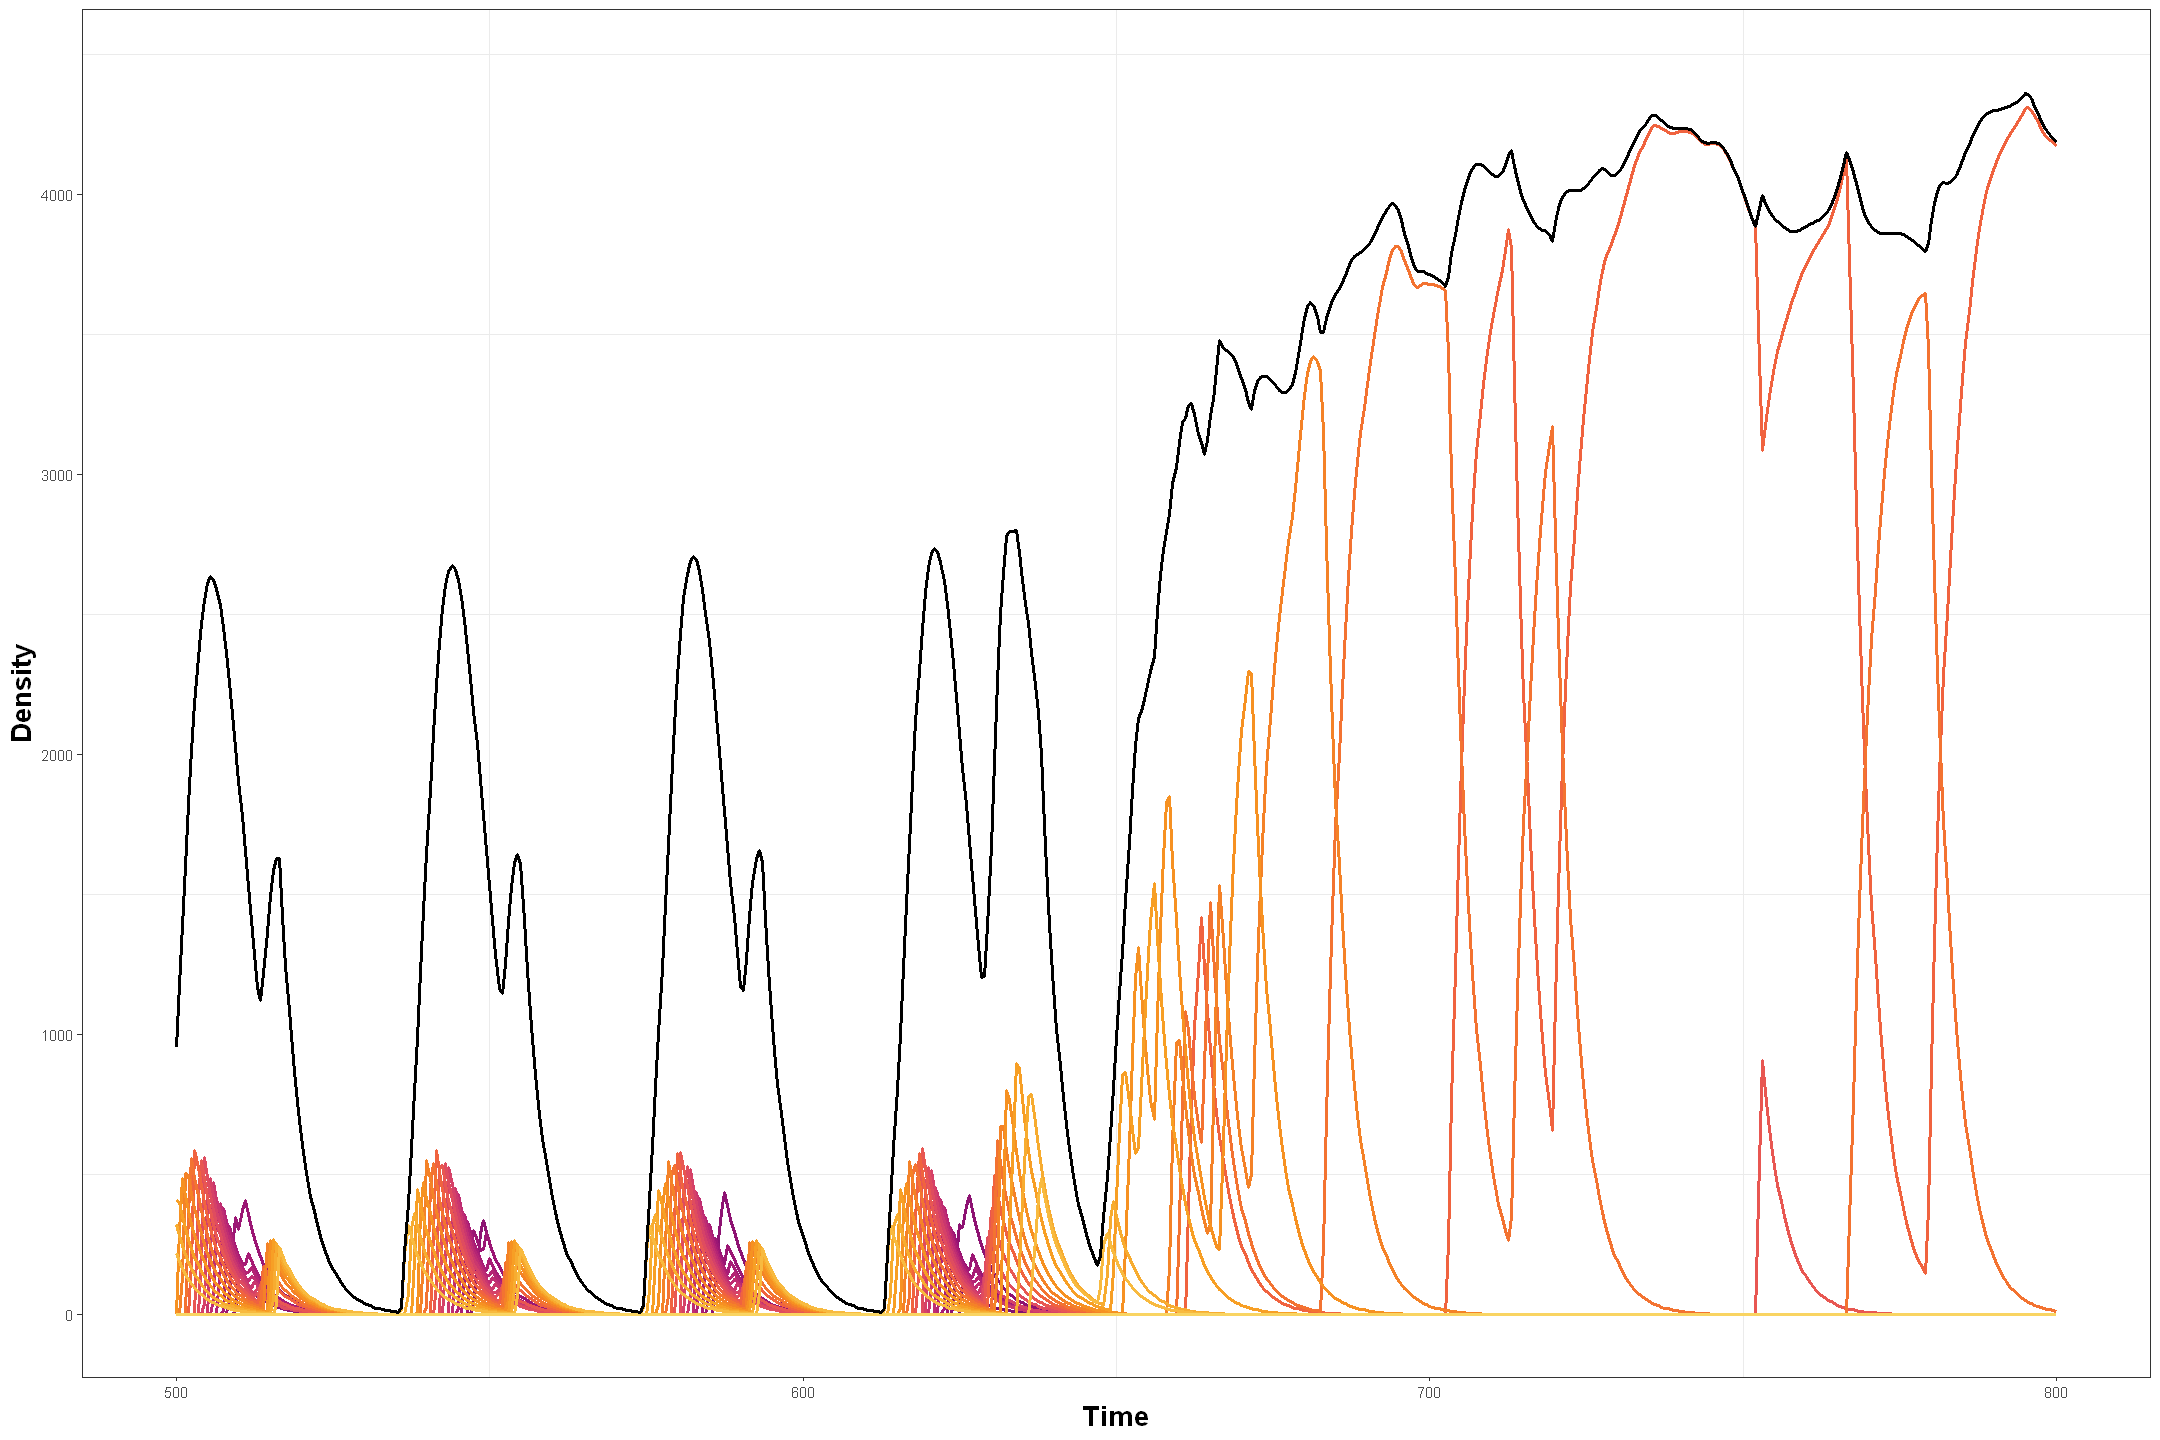

In [15]:
  a_f_1 <- 2000                # Initial adult food supply
  a_f_2 <- 1200                # Subsequent adult food supply
  switch_time = 610            # Time at which food supplies switch (can be made negative or very large to represent a single food condition)

  blowfly <- dde(y0, times, my_grad, parms = parms, hbsize = 1000000)


  ###################################################################################################

  #Produces plots etc.

  numbs <- n + 3
  palette <- sequential_hcl(n, palette = "Inferno")

  blowfly <- blowfly %>%
    mutate(sum = rowSums(.[4:numbs])) %>%
   filter(time %% 0.5 == 0)

  A <-
    lapply(4:numbs, function(i)
      paste0(
        'geom_line(color = palette[',i ,'-3], aes(x = blowfly[,1], y = blowfly[,',i,'+3], color = "Comp"), lwd=1) + '
      ))
  B <- paste0(A[1:(n-2)], collapse = "")
  C <-
    paste0(
      'plot2 <- ggplot() +', B,
     'geom_line(data = blowfly, color = "black", aes(x = blowfly[,1], y = sum, color = "Total Adults"), lwd = 1) +
      #geom_line(data = Nicholson_Data, color = "black", aes(x = V1, y = V2), linetype = "dashed", lwd = 1) +
      xlim(500,800) + xlab("Time") + ylab("Density")+ theme_bw() + theme(legend.direction = "vertical", legend.box = "vertical") +
      theme( axis.title=element_text(size=16,face="bold"), panel.grid.major = element_blank(), legend.text=element_text(size=13))  +
      scale_fill_gradientn(name="Proportion \nof individuals\n", colors=palette, labels=c("0","0.5","1"), breaks=c(0,0.5,1),limits=c(0,1)) +
      scale_color_manual(name = "Average trait value") + theme(legend.position="bottom")'
    )
  eval(parse(text = C))
  plot2

We can incorporate exactly the same mechanism, the idea of the effect of larval competition following through to alter adult trait directly into a mosquito model.

# Aedes albopictus and dengue

We finally come to a environmentally driven system of delay differential equations that describe the transmission of dengue by Aedes albopictus (as described fully in https://www.nature.com/articles/s41467-024-52144-5). We incorporate temperature dependent variable delays along side the persistant effects of larval competition on adult trait. There are many additional biological processes represented within the model, such as egg diapause, and resource dynamics, but all are constructed by combining the building blocks we've developed throughout the tutorial. A schematic representation of the model is shown below.  

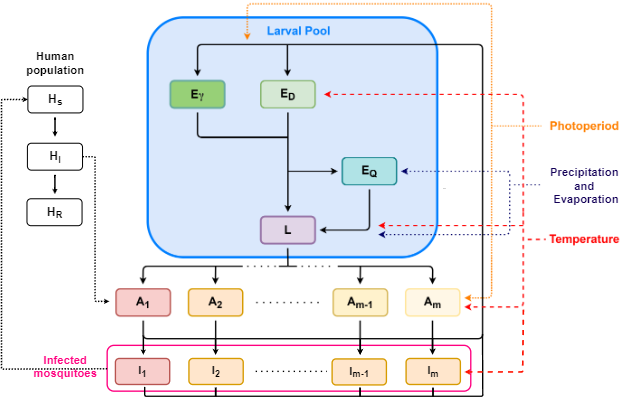

This model also contains both a human population and an infection structure the flow of individuals through the infection structure is mediated by delays - some temperature dependent (like the EIP) and some constant (like the IIP). In each of the following examples we introduce first a mosquito population and then, once the population has been established infected humans. 



We first simulate the model in Cagnes-sur-Mer, France and compare the oviposition dynamics to those observed by Marini et al. (XXXX). The following code is written in Julia for computational efficiency but for those unfamiliar the syntax should not be too hard to follow.

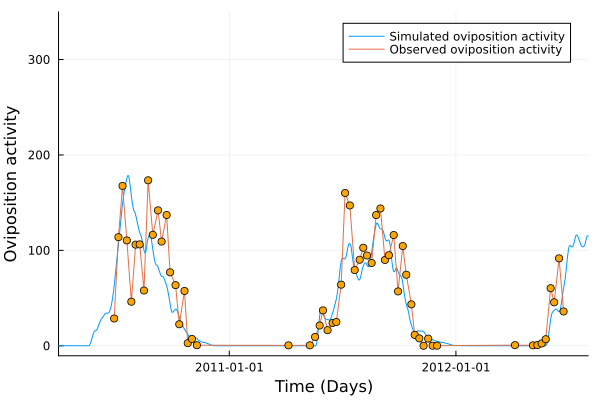

In [11]:
using(Dates)
using(DifferentialEquations)
using(Dierckx)
using(Plots)
using(CSV)
using(Interpolations)
using(QuadGK)
using(Statistics)
using(DataFrames)

function movingaverage(X::Vector,numofele::Int)
    BackDelta = div(numofele,2)
    ForwardDelta = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1
    len = length(X)
    Y = similar(X)
    for n = 1:len
        lo = max(1,n - BackDelta)
        hi = min(len,n + ForwardDelta)
        Y[n] = mean(X[lo:hi])
    end
    return Y
end

include("RMSE_fit.jl")
pal = get_color_palette(:auto, plot_color(:white))


#Alpes-Martimes 2020

lat = 43.67             #Latitude of simulation location
tspan = (0.0, 2508.0);  # Number of days to be simulated
pop = 2088.012 .* 4;    # Human population density

#Infection function
function infect(time) 
 if mod(time,365) >= 140  && mod(time,365) <= 141  && time > 1095
    impulse = 1
  else
    impulse = 0
  end
  return(impulse)
end;

#Era5-land variables needed to run the model 
Cag_Clim = CSV.read(raw"Cag_Clim.csv", header=true, DataFrame)

#Data from Marini et al. 
Cagnes_Eggs = CSV.read(raw"Cagnes_Eggs.csv", header=false, DataFrame)

Cag_Temp = Cag_Clim[:,3]
Cag_Prec = Cag_Clim[:,4]
Cag_EV   = Cag_Clim[:,5]

#Turns temperature data into splines
Precip_spl = Spline1D(collect(range(1,2508,length = 2508)),Cag_Prec[2193:4700])
Temps_spl = Spline1D(collect(range(1,2508,length = 2508)),Cag_Temp[2193:4700])
EV_spl = Spline1D(collect(range(1,2508,length = 2508)),Cag_EV[2193:4700])

#Runs the model - feel free to open this up and unpack it
include("SO2.jl")

#Various calculations for plotting the output
Egg_sum_cag = Ovi_Obs
solcag = 1:2508

cag_fit = RMSE_fun(movingaverage(Egg_sum_cag ,7),solcag,Cagnes_Eggs,8, 1460, 0.1,0.001)
Daily_inf_cag20 = (vector_human.(Temp.(sol.t .- 4)) .* bite.(Temp.(sol.t .- 4)))   .*  40 .* 4 .* inf_sum .* out[numb_H_S,:] ./ (out[numb_H_S,:] .+ out[numb_H_I,:] .+ out[numb_H_R,:]  .+ 15000   )

dt = DateTime(2006,1,1)
              min_date = DateTime(2010,4,1)
              max_date = DateTime(2012,8,1)
            time_axis = add_float2datetime.(1:2508,dt)
            time_axis2 = add_float2datetime.(sol.t,dt)

gcag = plot(time_axis,movingaverage(Egg_sum_cag,7) .* cag_fit[3]  , label = "Simulated oviposition activity", xlabel = "Time (Days)", ylabel = "Oviposition activity")
        plot!(add_float2datetime.(Cagnes_Eggs[:,1] .+ 1460 .+ cag_fit[2],dt)  , Cagnes_Eggs[:,2]     ,   label = "Observed oviposition activity" )
        plot!(add_float2datetime.(Cagnes_Eggs[:,1] .+ 1460 .+ cag_fit[2],dt)  , Cagnes_Eggs[:,2]     ,   label = nothing, seriestype =:scatter, color=:orange)
        plot!(xlims = Dates.value.([min_date,max_date]))
        plot!(ylim = (-10.5,350))

daily_cag20 = plot(time_axis2, (Daily_inf_cag20  ) , label ="Simulated dengue cases" , ylabel = "Number of new cases", xlabel = "Time (days)")
                  plot!(xlims = Dates.value.([min_date,max_date]))

display(gcag)

We then examine predictions of the number of human infections. Try changing how many and when infected people are introduced as well as the size of the human population.

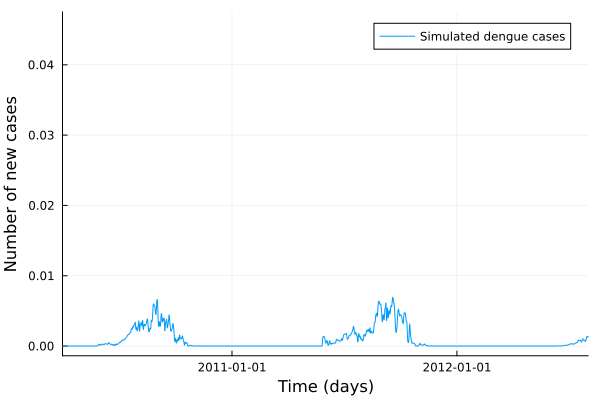

In [12]:
display(daily_cag20)

Now try running the model under environmental conditions corresponding to Guangzhou in 2013/14. 

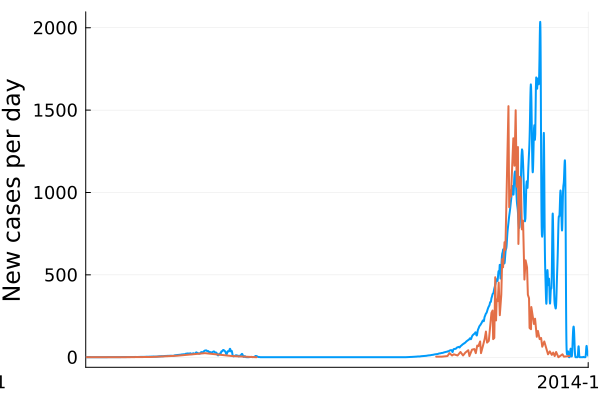

In [13]:
##Guangzhou 2013 & 2014

lat   = 23.1291
tspan = (0.0, 1461.0);
pop   = 32113.22 * 4;

function infect(time)
  if mod(time,365) >= 151  && mod(time,365) <= 190 && time > 1095
     impulse = 0.25
 elseif mod(time,365) >= 153  && mod(time,365) <= 154  && time < 1095 && time > 730
     impulse =0.25
   else
     impulse = 0
   end
   return(impulse)
end;
 
Guang_Clim = CSV.read(raw"Gua_Clim.csv", header=true,DataFrame)

Guang_Temp = Guang_Clim[:,3]
Guang_Prec = Guang_Clim[:,4]
Guang_EV   = Guang_Clim[:,5]

Precip_spl = Spline1D(collect(range(1,1461,length = 1461)), Guang_Prec[4019:5479])
Temps_spl  = Spline1D(collect(range(1,1461,length = 1461)) ,Guang_Temp[4019:5479])
EV_spl     = Spline1D(collect(range(1,1461,length = 1461)) ,  Guang_EV[4019:5479])

Gua_D_13   = CSV.read(raw"Gua_13_R.csv", header=false,DataFrame)
Gua_D_14   = CSV.read(raw"G_D_14.csv", header=false,DataFrame)

include("SO2.jl")
 
solgua14       = sol.t
inf_sum_2014   = inf_sum
adult_sum_2014 = adult_sum
H_I_2014       = out[numb_H_I,:]
H_R_2014       = out[numb_H_R,:]
H_S_2014       = out[numb_H_S,:]
out_gua        = out

Daily_inf_2014 = (vector_human.(Temp.(sol.t .- 4)) .* bite.(Temp.(sol.t .- 4)))   .*   40 .* 4 .* inf_sum .* out[numb_H_S,:] ./ (out[numb_H_S,:] .+ out[numb_H_I,:] .+ out[numb_H_R,:] .+ 15000   )

dt = DateTime(2011,1,1)
      min_date = DateTime(2013,6,1)
      max_date = DateTime(2014,12,31)
      time_axis = add_float2datetime.(solgua14,dt)
      time_axis2 = add_float2datetime.(1:1461,dt)

      
gH_I_2014 = Plots.plot(time_axis, H_I_2014 ,label = "Simulated dengue cases", xlabel = "Time (Days)", ylabel = "Dengue Cases")
                      plot!(xlims = Dates.value.([min_date,max_date]))
                      plot!(add_float2datetime.(Gua_D_14[:,1]  .+ 1095 ,dt),(Gua_D_14[:,2]), label = "Observed dengue cases")
                      plot!(time_axis, H_S_2014, legend = false, xlabel = "Time (Days)", ylabel = "Number of Larvae")
                      plot!(time_axis, H_R_2014 , legend = false, xlabel = "Time (Days)", ylabel = "Number of Larvae")

daily_2014 = plot(time_axis, (Daily_inf_2014 .* 13.5),label = nothing, ylabel = "New cases per day", linewidth = 2, xtickfontsize=12, ytickfontsize=12, xguidefontsize=16, yguidefontsize=16)
                      plot!(xlims = Dates.value.([min_date,max_date]))
                      plot!(add_float2datetime.(Gua_D_14[:,1] .+ 1095    ,dt),(Gua_D_14[:,2]) ,label = nothing , linewidth = 2, color = pal[2], legendfontsize=10)
                      plot!(add_float2datetime.(Gua_D_13[:,1] .+ 730 .+ 14,dt),exp.(Gua_D_13[:,2]) ./ (31) , label = nothing, linewidth =2 , color = pal[2], legendfontsize=10)
                      plot!(xticks=(Dates.value.([DateTime(2013,1,1),DateTime(2014,12,31)]),["2013-01-01","2014-12-31"]))
